### Libraries import

In [ ]:
import csv
import math
import numpy as np
import pandas as pd
import random as rd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

In [ ]:
import warnings
warnings.filterwarnings("ignore")

###Spread function

In [ ]:
# Set parametrization for the cellular automaton
size = (50, 50)
number_of_days = 10000
crit = 4
matrix_orig = [[[0 for x in range(size[1]+2)] for y in range(size[0]+2)] for z in range(number_of_days)]

In [ ]:
# Function for generation of coordinates for new grains
# It can create more or less than one grain per round,
# if you switch it to the exponential or pareto mode
def grain_generator(size, number_of_days, dist = 'uni'):
  new_grains = []
  if dist == 'uni':
    for d in range(number_of_days):
      grain = [np.random.randint(1, size[0]+1), np.random.randint(1, size[1]+1)]
      new_grains.append([grain])
  elif dist == 'expon':
    num_of_grains = np.around(np.random.exponential(size = number_of_days))
    for d in range(number_of_days):
      grains = []
      for g in range(int(num_of_grains[d]) + 1):
        grain = [np.random.randint(1, size[0]+1), np.random.randint(1, size[1]+1)]
        grains.append(grain)
      new_grains.append(grains)
  elif dist == 'par':
    num_of_grains = np.around(np.random.pareto(a = 2, size = number_of_days))
    for d in range(number_of_days):
      grains = []
      for g in range(int(num_of_grains[d]) + 1):
        grain = [np.random.randint(1, size[0]+1), np.random.randint(1, size[1]+1)]
        grains.append(grain)
      new_grains.append(grains)
  else:
    print('Check available distributions.')
  return new_grains

In [ ]:
# Generation of the base list for coordinates of the new grains
new_grains = grain_generator(size, number_of_days)

In [ ]:
# Generation of the additional list for coordinates of the new grains on the exponential distribution
new_grains_exp = grain_generator(size, number_of_days, 'expon')

In [ ]:
# Generation of the additional list for coordinates of the new grains on the Pareto distribution
new_grains_par = grain_generator(size, number_of_days, 'par')

In [ ]:
# Set additional parametrization in case of higher dissipation from the system
new_grains_plus = grain_generator(size, number_of_days)
new_grains_minus = grain_generator(size, number_of_days)

In [ ]:
# Function for calculation of number of sand grains in and out of the model
def counter(matrix, d, new_grains, new_grains_plus, new_grains_minus):
  inner_d = 0
  outer_d = 0
  total_d = 0

  for i in range(1, len(matrix[0])-1):
    for j in range(1, len(matrix[0][0])-1):
      inner_d += matrix[d][i][j]
  for i in range(d+1):
    total_d += len(new_grains[i])
  if new_grains_plus != None:
    for i in range(d+1):
      total_d += len(new_grains_plus[i])
  if new_grains_minus != None:
    for i in range(d+1):
      total_d -= len(new_grains_minus[i])
  
  outer_d = total_d - inner_d + 1

  return inner_d, outer_d

In [ ]:
# Function for modelling of spread for Bak-Tang-Wiesenfeld, Manna, Feders
# and stochastic Feders base and facilitated models on cellular automatons.
# Also there is a possibility to change the regime of the system from +1 
# each turn to +2-1, which partially changes behaviour of the system,
# or to +1-1, which allows to avoid most of the falls.
# Another adjustment to the pumping algorithm was the addition of exponential
# distribution of the number of new grains on each turn.
def spread(model:str, 
           matrix, 
           number_of_days:int, 
           new_grains:list,
           facilitated:bool = False, 
           ad_dissipation:bool = False,
           neutral_state:bool = False,
           expon:bool = False,
           par:bool = False,
           new_grains_plus:list = None,
           new_grains_minus: list = None, 
           crit = 4):

  inner = []
  outer = []
  falls = []

  if facilitated == True:
    facilit_matrix = [[[0 for x in range(size[1]+2)] for y in range(size[0]+2)] for z in range(number_of_days)]

  for d in tqdm(range(len(matrix))):
    falls_d = 0
    for g in range(len(new_grains[d])):
      matrix[d][new_grains[d][g][0]][new_grains[d][g][1]] += 1
    if ad_dissipation == True:
      for g in range(len(new_grains[d])):
        matrix[d][new_grains_plus[d][g][0]][new_grains_plus[d][g][1]] += 1
        matrix[d][new_grains_minus[d][g][0]][new_grains_minus[d][g][1]] -= 1
    if neutral_state == True:
      for g in range(len(new_grains[d])):
        matrix[d][new_grains_minus[d][g][0]][new_grains_minus[d][g][1]] -= 1
    for i in range(len(matrix[0])):
      for j in range(len(matrix[0][0])):
        if d<=(len(matrix)-2):
          matrix[d+1][i][j] += matrix[d][i][j]
    for i in range(len(matrix[0])):
      for j in range(len(matrix[0][0])):
        if facilitated == False:
          if d<=(len(matrix)-2) and 1<=i<=(len(matrix[0])-2) and 1<=j<=(len(matrix[0][0])-2) and matrix[d][i][j] >= crit:
            if model == "BTW":
              matrix, falls_d = BTW(matrix, falls_d, d, i, j, crit)
            if model == "MA":
              matrix, falls_d = MA(matrix, falls_d, d, i, j, crit)
            if model == "FE":
              matrix, falls_d = FE(matrix, falls_d, d, i, j, crit)    
            if model == "SFE":
              matrix, falls_d = SFE(matrix, falls_d, d, i, j, crit)
        else:
          if d<=(len(matrix)-2) and 1<=i<=(len(matrix[0])-2) and 1<=j<=(len(matrix[0][0])-2) and (matrix[d][i][j] >= crit or facilit_matrix[d][i][j] >= 2):
            if model == "BTW":
              matrix, facilit_matrix, falls_d = BTW_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)
            if model == "MA":
              matrix, facilit_matrix, falls_d = MA_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)
            if model == "FE":
              matrix, facilit_matrix, falls_d = FE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)    
            if model == "SFE":
              matrix, facilit_matrix, falls_d = SFE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)

    inner_d, outer_d = counter(matrix, d, new_grains, new_grains_plus, new_grains_minus)
    inner.append(inner_d)
    outer.append(outer_d)
    if d <= len(matrix)-2:
      falls.append(falls_d)

  for d in range(len(matrix)):
    for i in range(len(matrix[0])):
      for j in range(len(matrix[0][0])):
        matrix[d][i][j] = 0

  # print(inner)
  # print(outer)
  # print(falls)
  data = pd.DataFrame(falls)
  ca_name = model
  if facilitated == True: 
    ca_name = ca_name + '_fa'
  if ad_dissipation == True: 
    ca_name = ca_name + '_ad'
  if neutral_state == True:
    ca_name = ca_name + '_ns'
  if expon == True:
    ca_name = ca_name + '_exp'
  if par == True:
    ca_name = ca_name + '_par'

  data.to_csv('CA_SOC/' + ca_name + '.csv', index=False)

  fig, axs = plt.subplots(2, 1, figsize=(15, 10))
  axs[0].xaxis.get_major_locator().set_params(integer=True)
  axs[0].yaxis.get_major_locator().set_params(integer=True)
  axs[1].xaxis.get_major_locator().set_params(integer=True)
  axs[1].yaxis.get_major_locator().set_params(integer=True)
  axs[0].set(ylim=(0, 10000))
  axs[1].set(ylim=(0, 250))
  axs[0].plot(list(range(number_of_days)), inner, color='#40a6d1', alpha = 0.5, label = "Inner Grains")
  axs[0].plot(list(range(number_of_days)), outer, color='red', alpha = 0.5, label = "Outer Grains")
  axs[0].legend(loc = 'upper right', fontsize='medium')
  axs[0].set_title('Number of grains in and out of the ' + ca_name + ' model')
  axs[1].plot(list(range(number_of_days-1)), falls, color='#40a6d1', alpha = 0.5)
  axs[1].set_title('Number of falls in the ' + ca_name + ' model')
  plt.setp(axs[0], xlabel='Day', ylabel='Grains')
  plt.setp(axs[1], xlabel='Day', ylabel='Falls')
  plt.tight_layout()
  plt.show()

### Model definition

In [ ]:
def BTW(matrix, falls_d, d, i, j, crit):
  falls_d += 1
  matrix[d+1][i-1][j] += 1
  matrix[d+1][i+1][j] += 1
  matrix[d+1][i][j-1] += 1
  matrix[d+1][i][j+1] += 1
  matrix[d+1][i][j] -= crit

  return matrix, falls_d

In [ ]:
def BTW_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    matrix[d+1][i-1][j] += 1
    matrix[d+1][i+1][j] += 1
    matrix[d+1][i][j-1] += 1
    matrix[d+1][i][j+1] += 1
    matrix[d+1][i][j] -= crit
    facilit_matrix[d+1][i-1][j] += 1
    facilit_matrix[d+1][i+1][j] += 1
    facilit_matrix[d+1][i][j-1] += 1
    facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

In [ ]:
def MA(matrix, falls_d, d, i, j, crit):
  falls_d += 1
  n_1 = rd.randint(0, crit)
  n_2 = rd.randint(0, crit-n_1)
  n_3 = rd.randint(0, crit-n_1-n_2)
  n_4 = crit - n_1 - n_2 - n_3
  matrix[d+1][i-1][j] += n_1
  matrix[d+1][i+1][j] += n_2
  matrix[d+1][i][j-1] += n_3
  matrix[d+1][i][j+1] += n_4
  matrix[d+1][i][j] -= crit

  return matrix, falls_d

In [ ]:
def MA_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    n_1 = rd.randint(0, crit)
    n_2 = rd.randint(0, crit-n_1)
    n_3 = rd.randint(0, crit-n_1-n_2)
    n_4 = crit - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= crit
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

In [ ]:
def FE(matrix, falls_d, d, i, j, crit): 
  falls_d += 1
  matrix[d+1][i-1][j] += 1
  matrix[d+1][i+1][j] += 1
  matrix[d+1][i][j-1] += 1
  matrix[d+1][i][j+1] += 1
  matrix[d+1][i][j] -= matrix[d][i][j]

  return matrix, falls_d

In [ ]:
def FE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    matrix[d+1][i-1][j] += 1
    matrix[d+1][i+1][j] += 1
    matrix[d+1][i][j-1] += 1
    matrix[d+1][i][j+1] += 1
    matrix[d+1][i][j] -= matrix[d][i][j]
    facilit_matrix[d+1][i-1][j] += 1
    facilit_matrix[d+1][i+1][j] += 1
    facilit_matrix[d+1][i][j-1] += 1
    facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

In [ ]:
def SFE(matrix, falls_d, d, i, j, crit):
  falls_d += 1
  n_1 = rd.randint(0, crit)
  n_2 = rd.randint(0, crit-n_1)
  n_3 = rd.randint(0, crit-n_1-n_2)
  n_4 = crit - n_1 - n_2 - n_3
  matrix[d+1][i-1][j] += n_1
  matrix[d+1][i+1][j] += n_2
  matrix[d+1][i][j-1] += n_3
  matrix[d+1][i][j+1] += n_4
  matrix[d+1][i][j] -= matrix[d][i][j]

  return matrix, falls_d

In [ ]:
def SFE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    n_1 = rd.randint(0, crit)
    n_2 = rd.randint(0, crit-n_1)
    n_3 = rd.randint(0, crit-n_1-n_2)
    n_4 = crit - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

### Bak-Tang-Wiesenfeld

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:48<00:00, 206.55it/s]


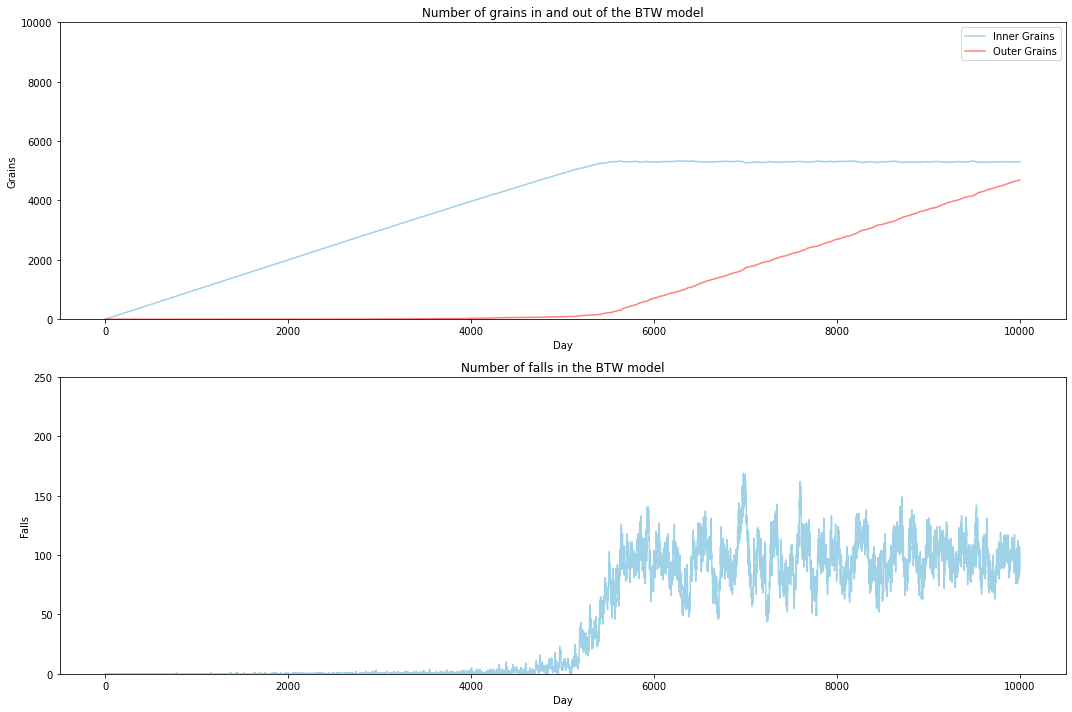

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:03<00:00, 156.81it/s]


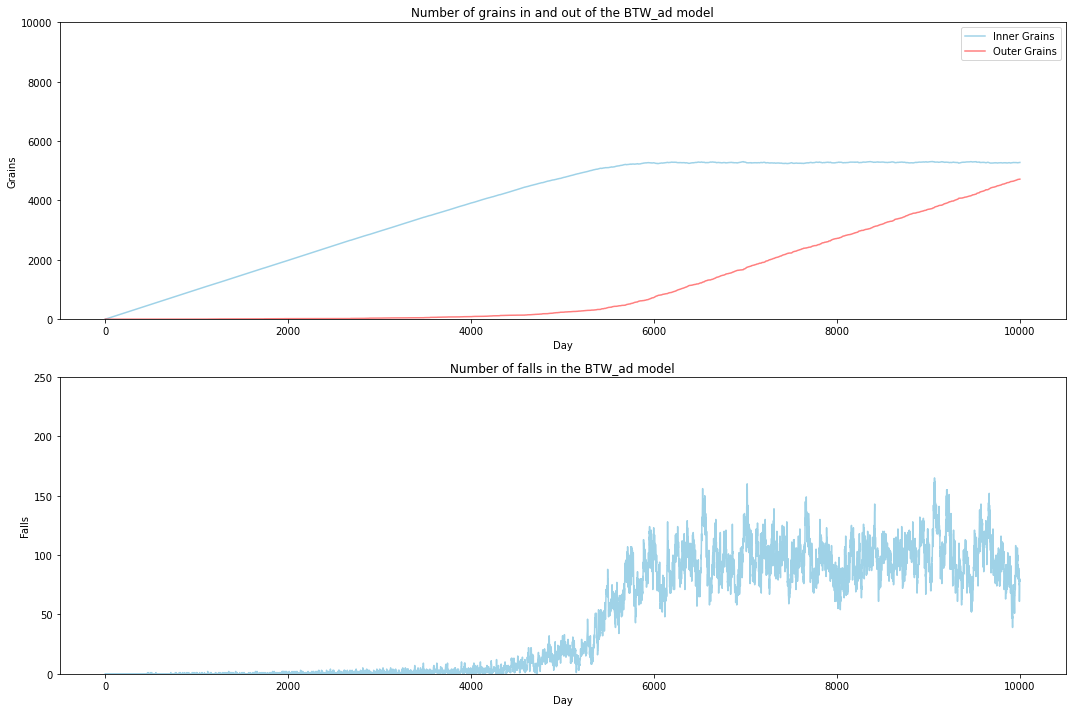

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:54<00:00, 185.16it/s]


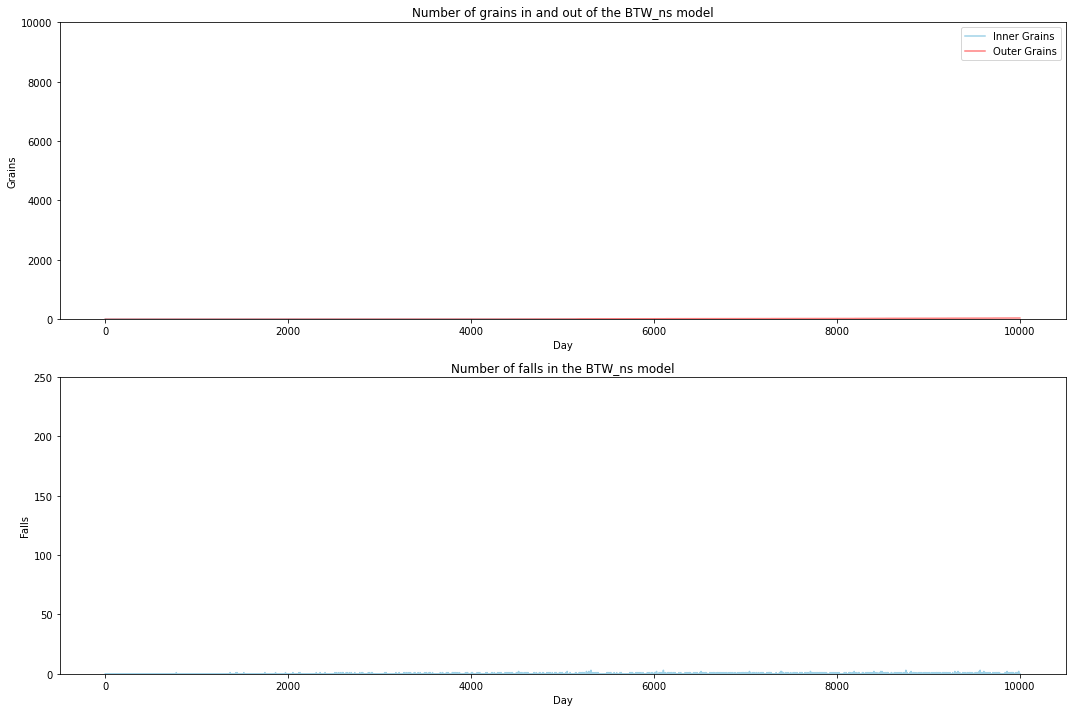

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:49<00:00, 204.04it/s]


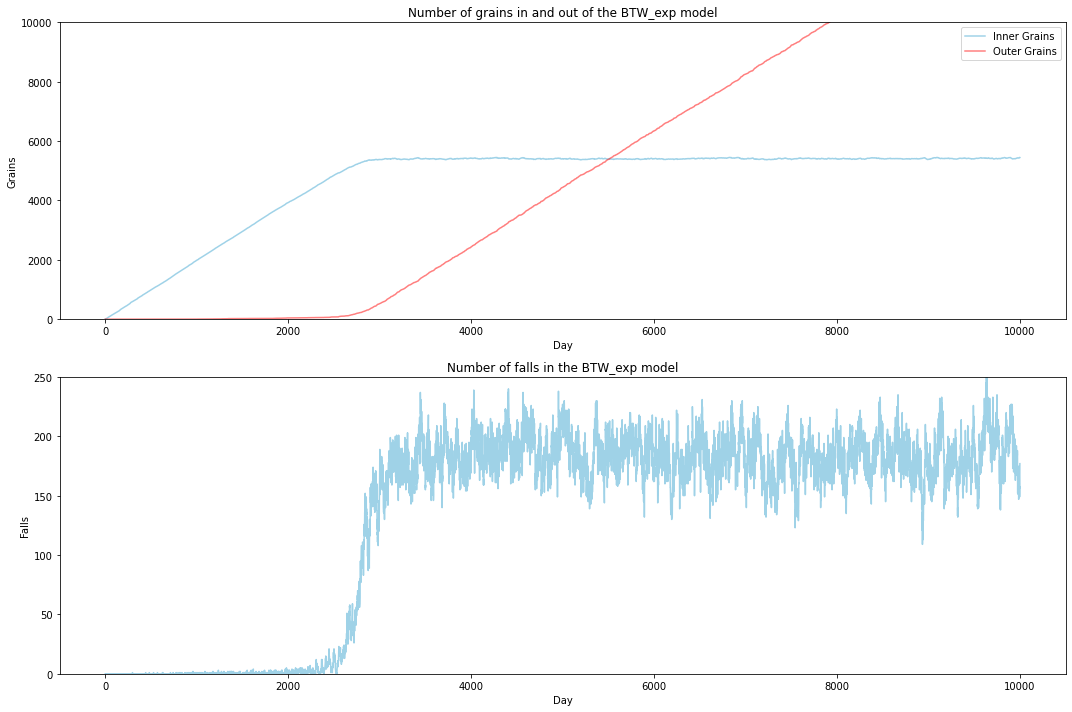

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains_exp, expon = True)

100%|██████████| 10000/10000 [00:54<00:00, 182.30it/s]


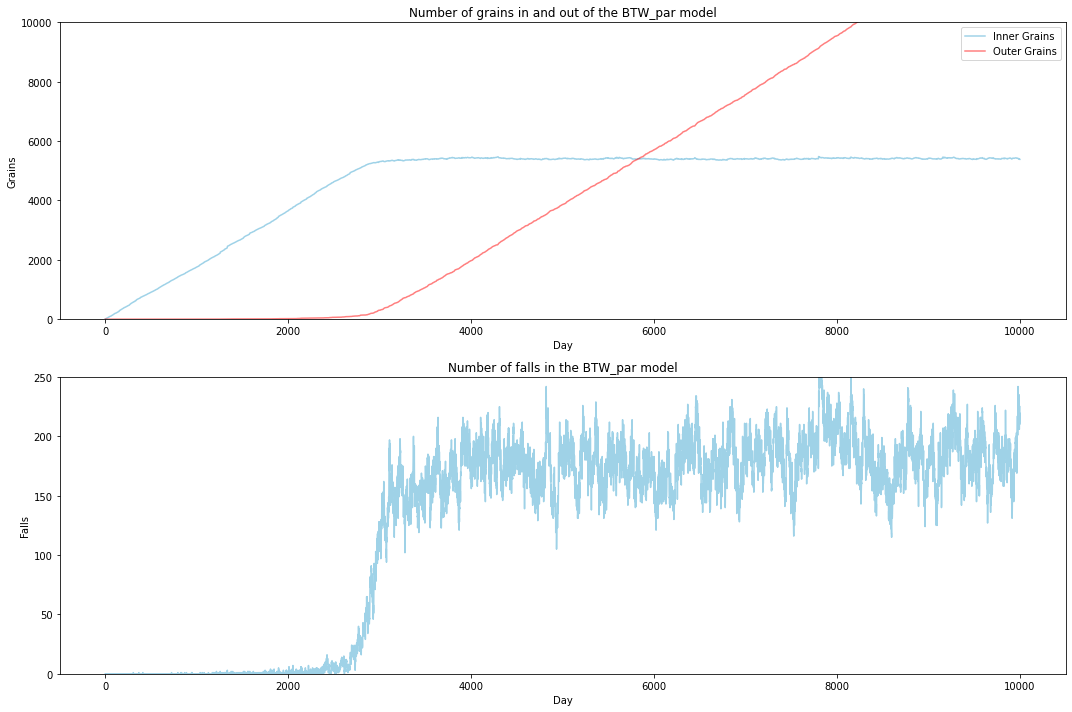

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains_par, par = True)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:50<00:00, 198.60it/s]


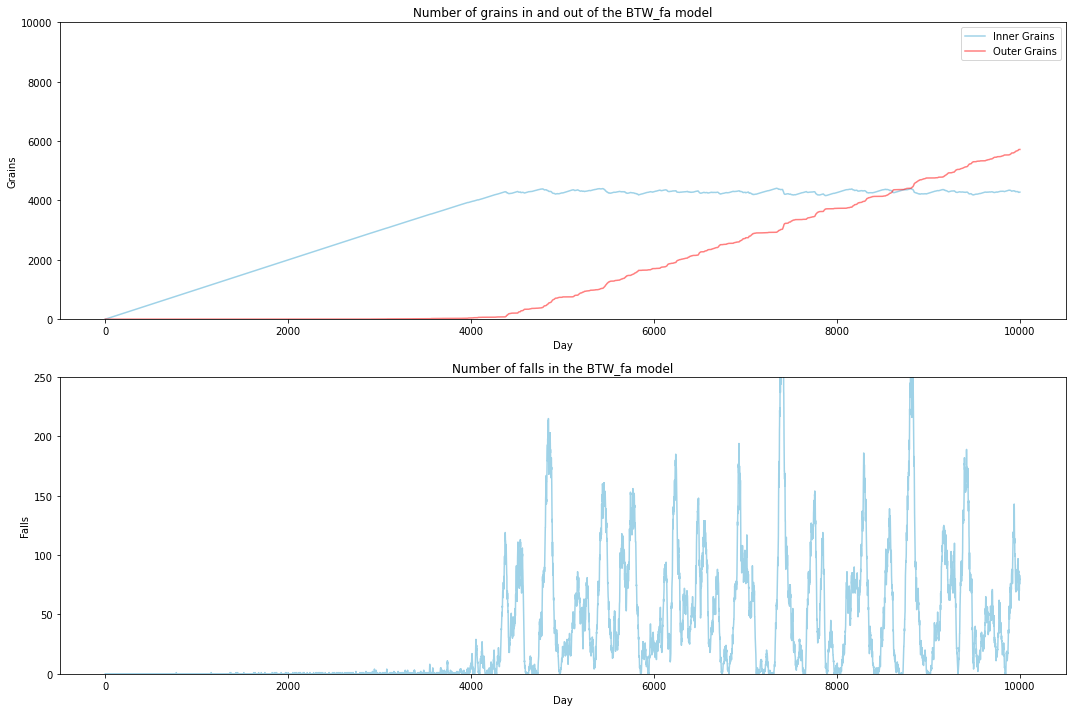

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:06<00:00, 150.50it/s]


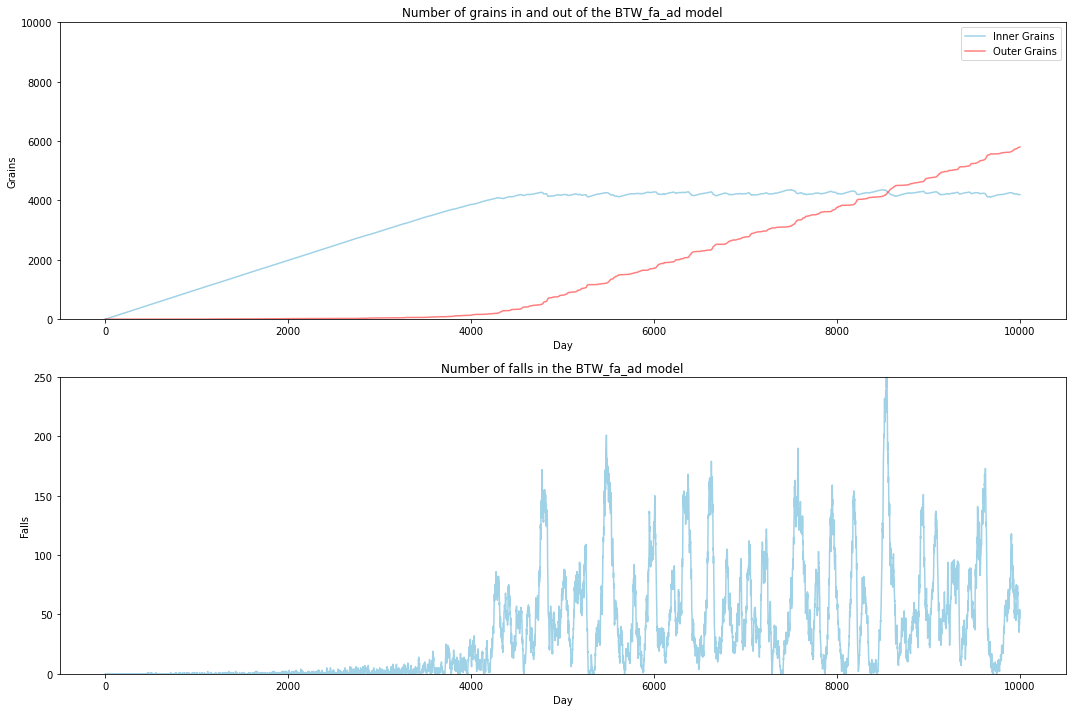

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:57<00:00, 173.33it/s]


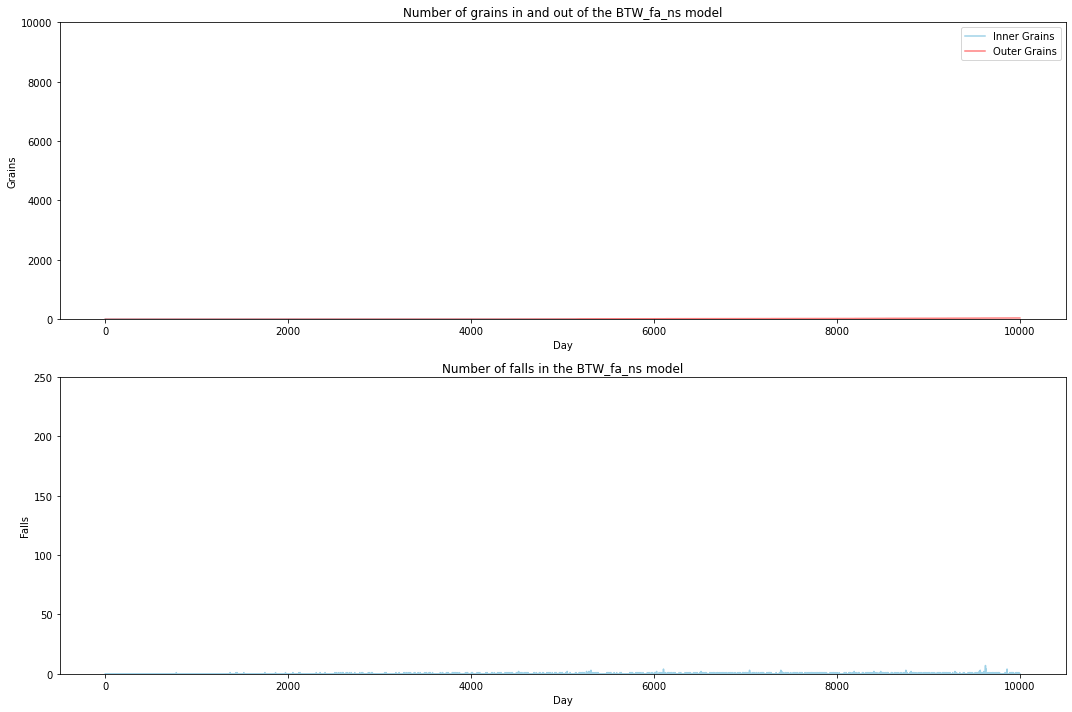

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:55<00:00, 179.38it/s]


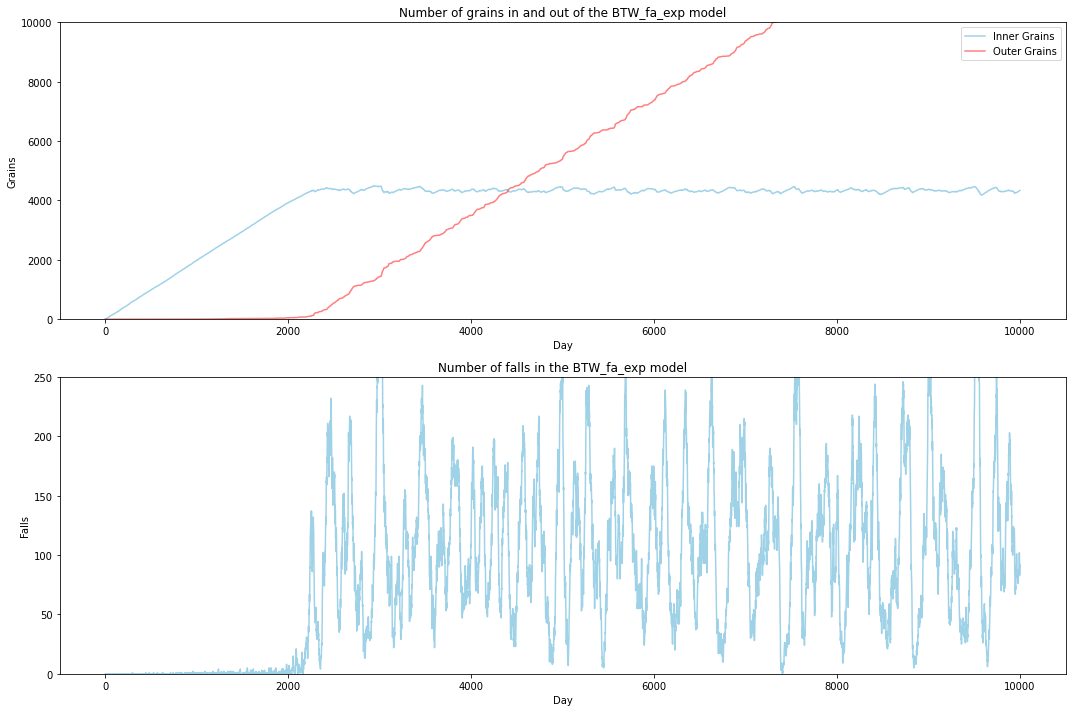

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains_exp, facilitated = True, expon = True)

100%|██████████| 10000/10000 [01:00<00:00, 166.54it/s]


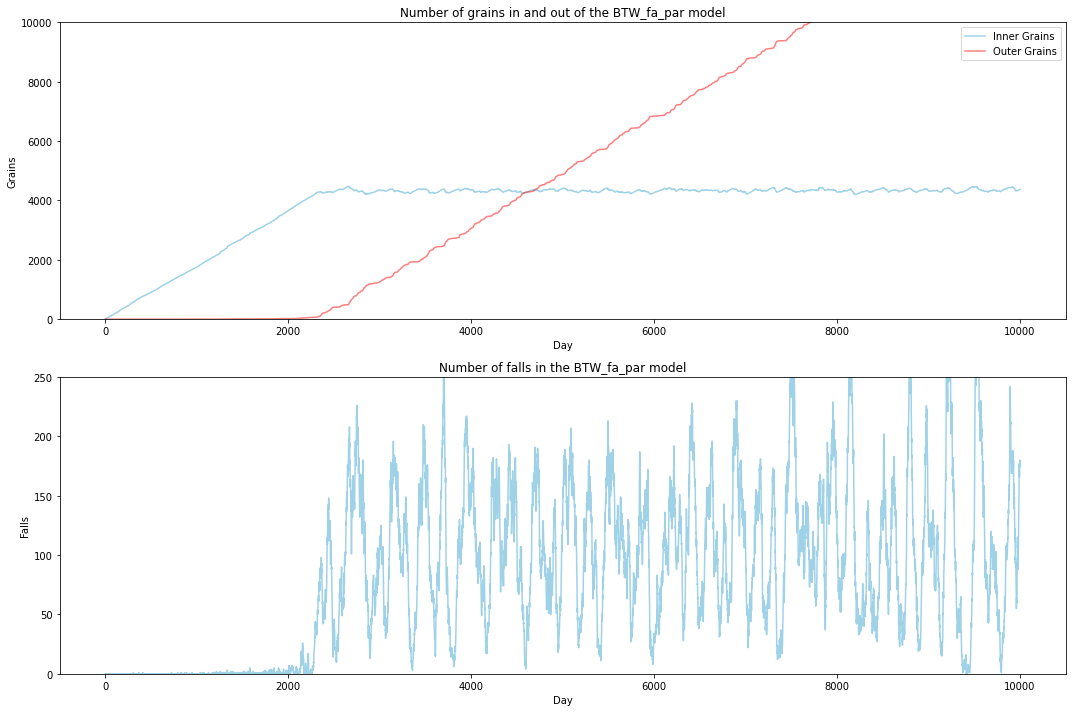

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains_par, facilitated = True, par = True)

### Mann

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:47<00:00, 209.81it/s]


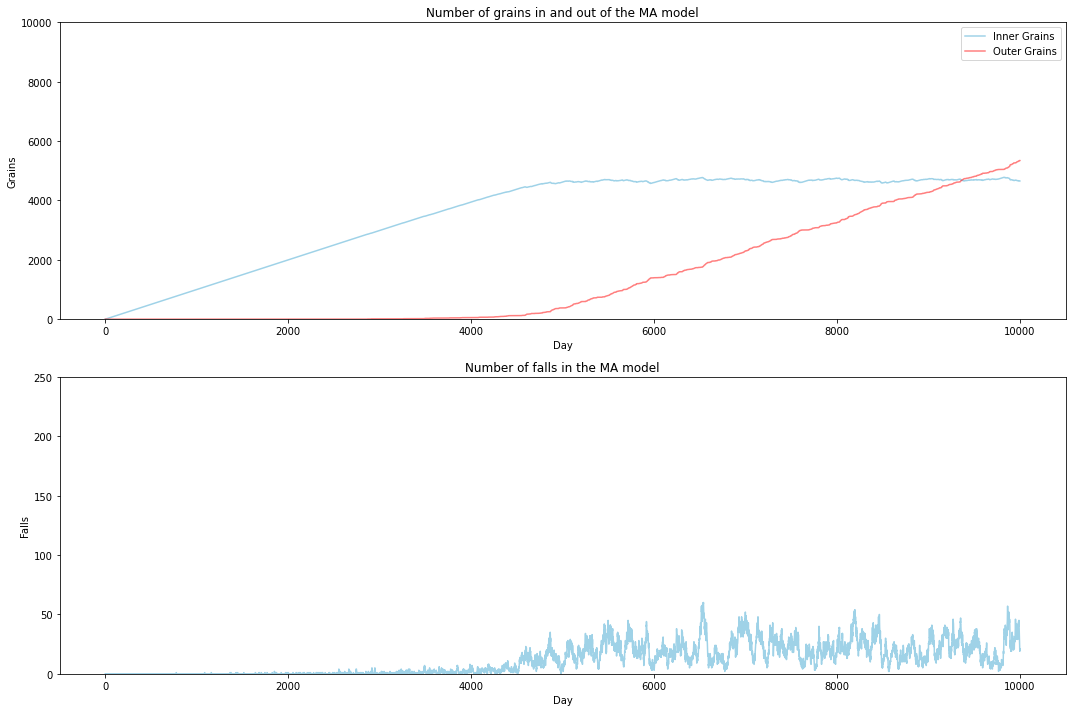

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:04<00:00, 155.42it/s]


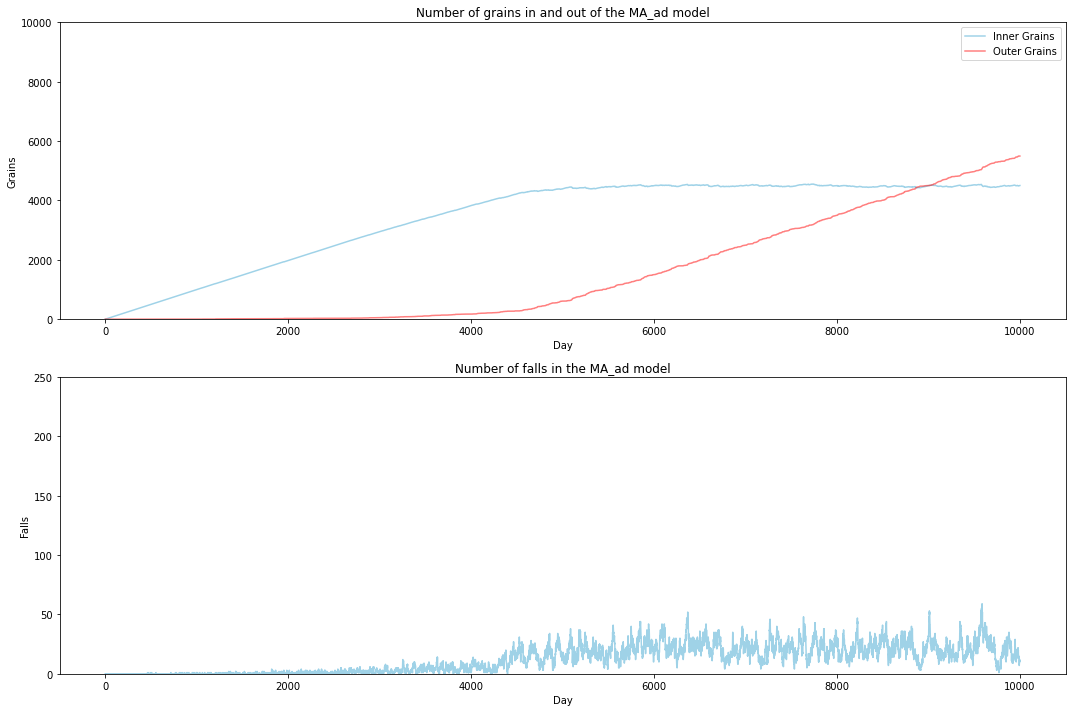

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:55<00:00, 181.33it/s]


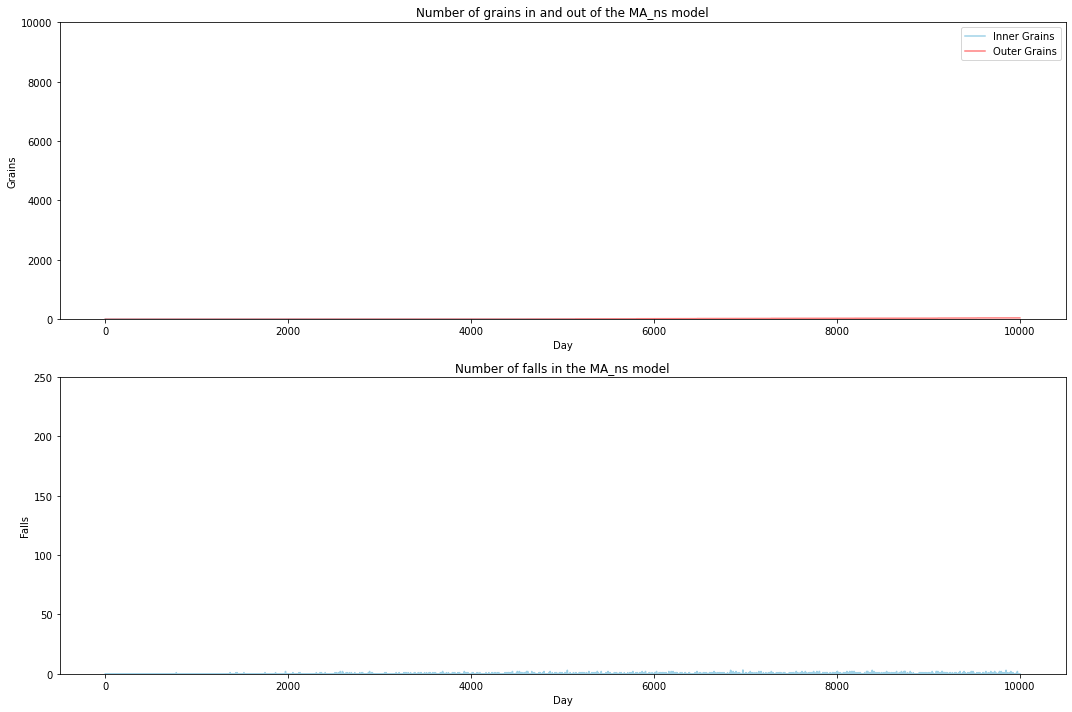

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:48<00:00, 204.82it/s]


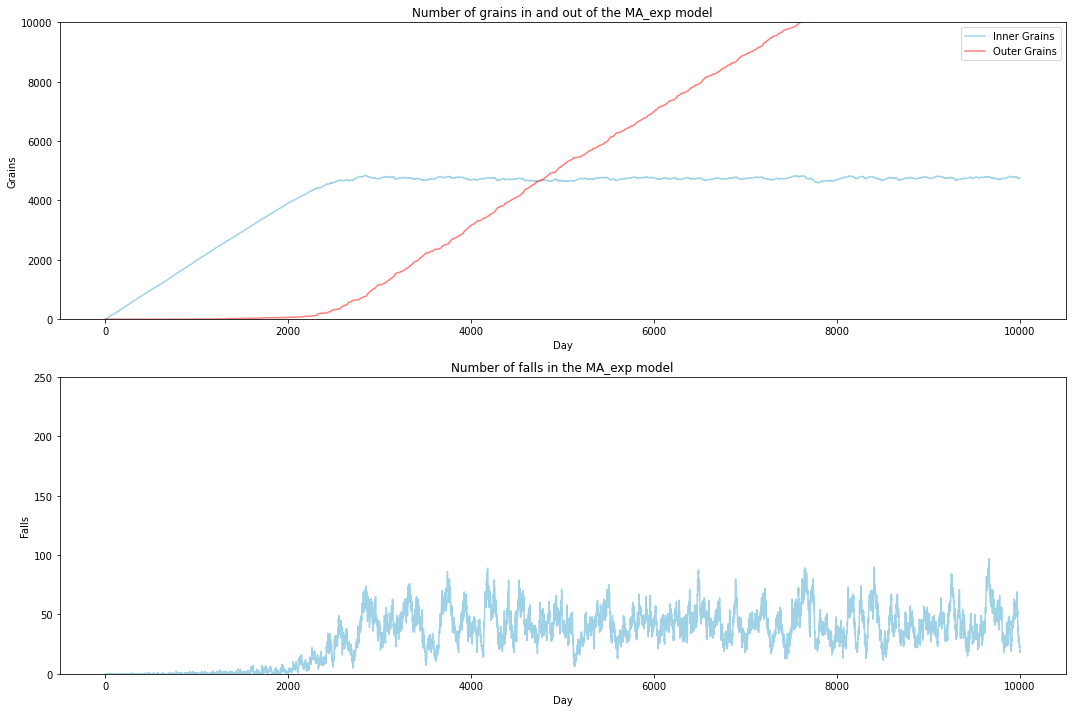

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains_exp, expon = True)

100%|██████████| 10000/10000 [00:49<00:00, 201.54it/s]


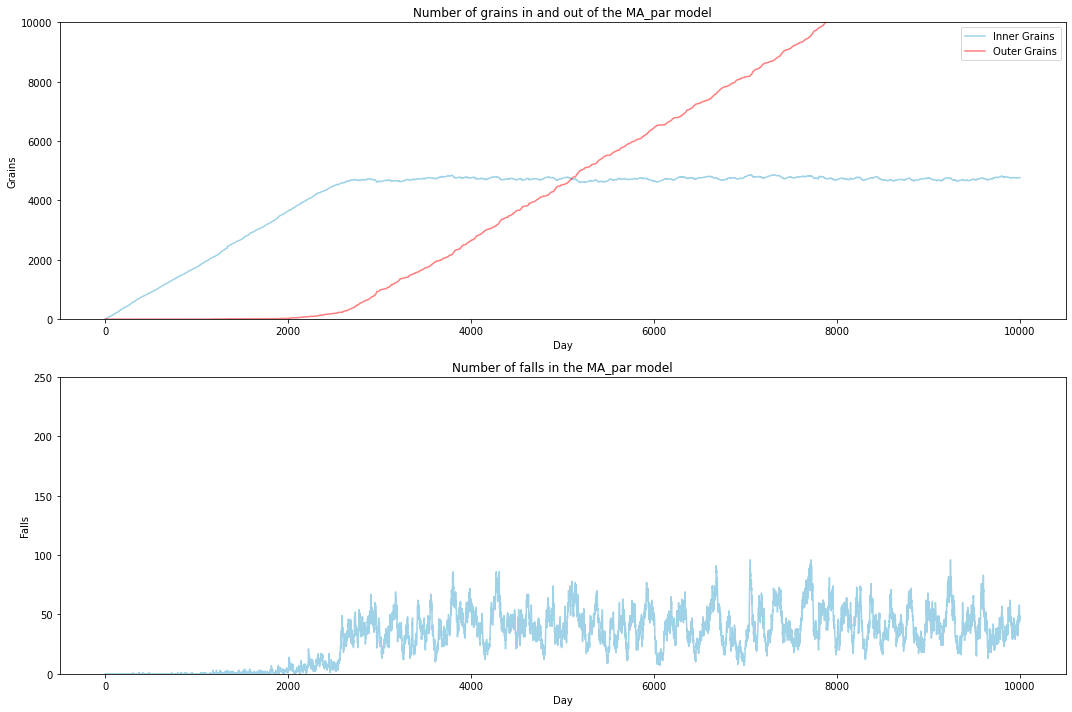

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains_par, par = True)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:52<00:00, 191.29it/s]


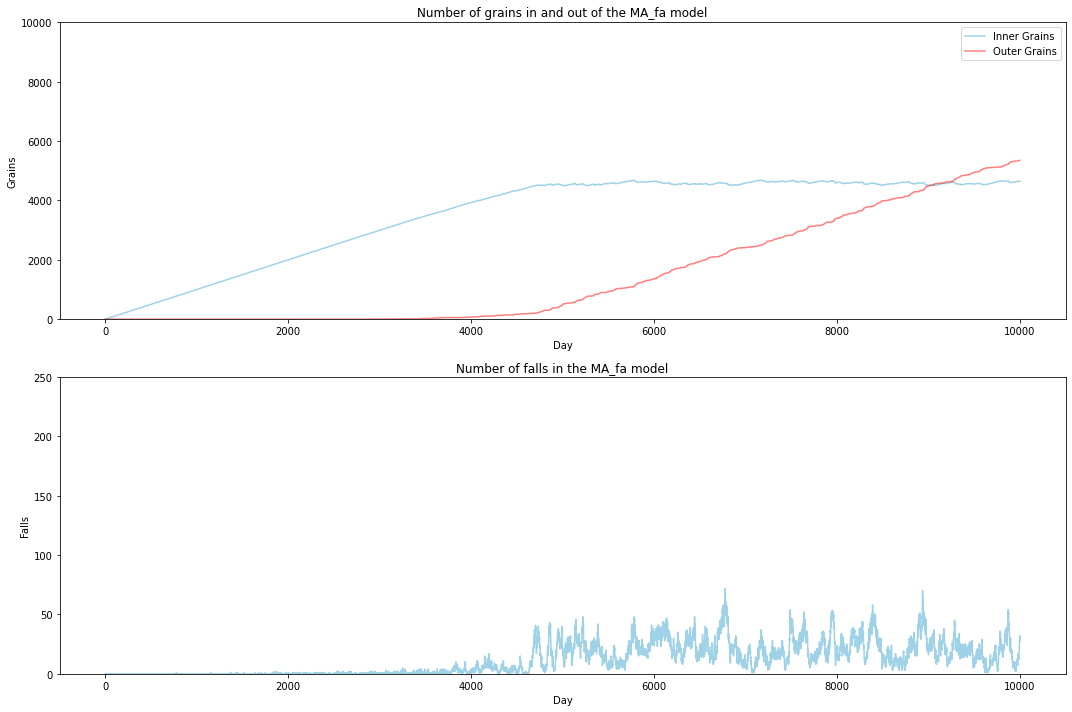

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:11<00:00, 139.33it/s]


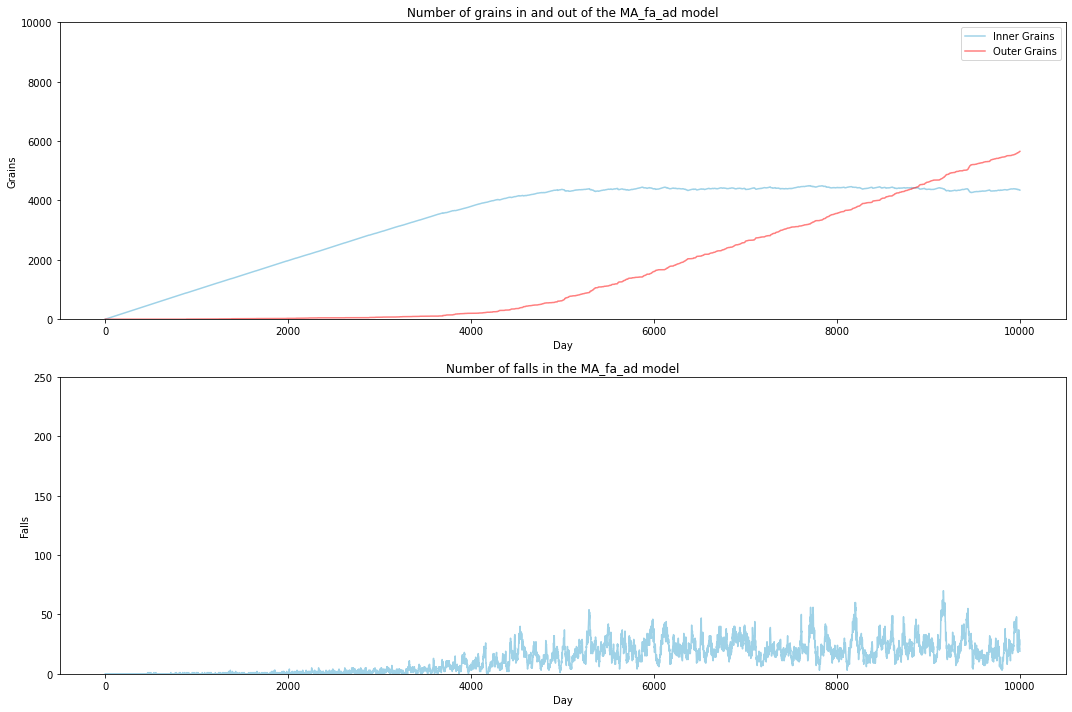

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:57<00:00, 172.53it/s]


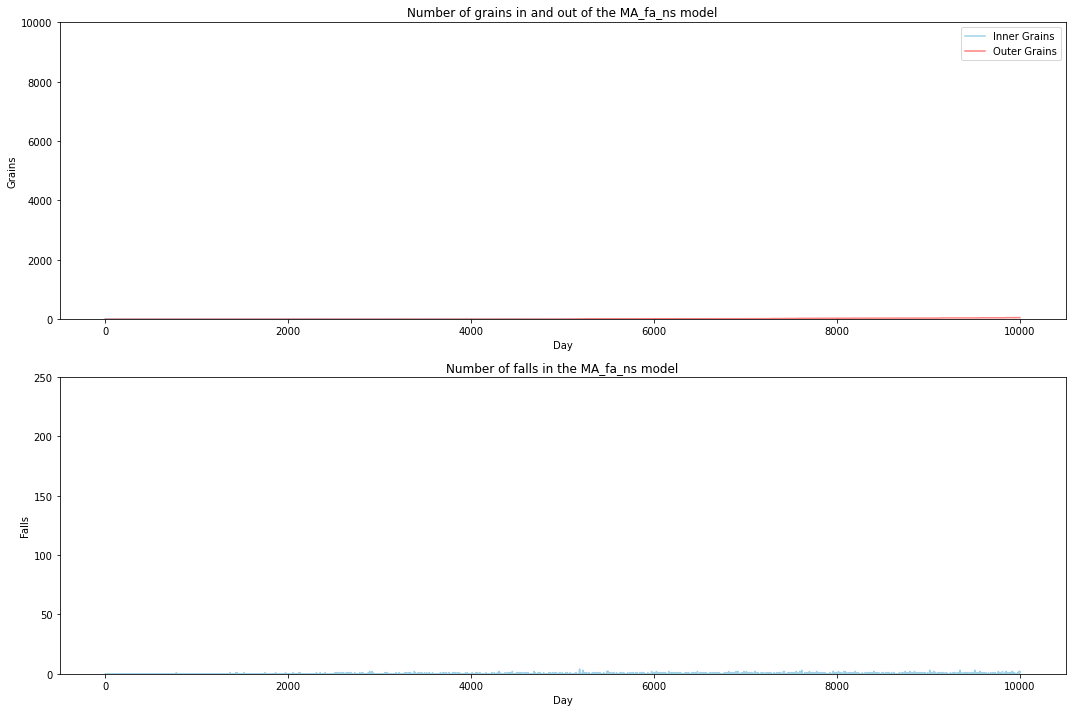

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:54<00:00, 185.13it/s]


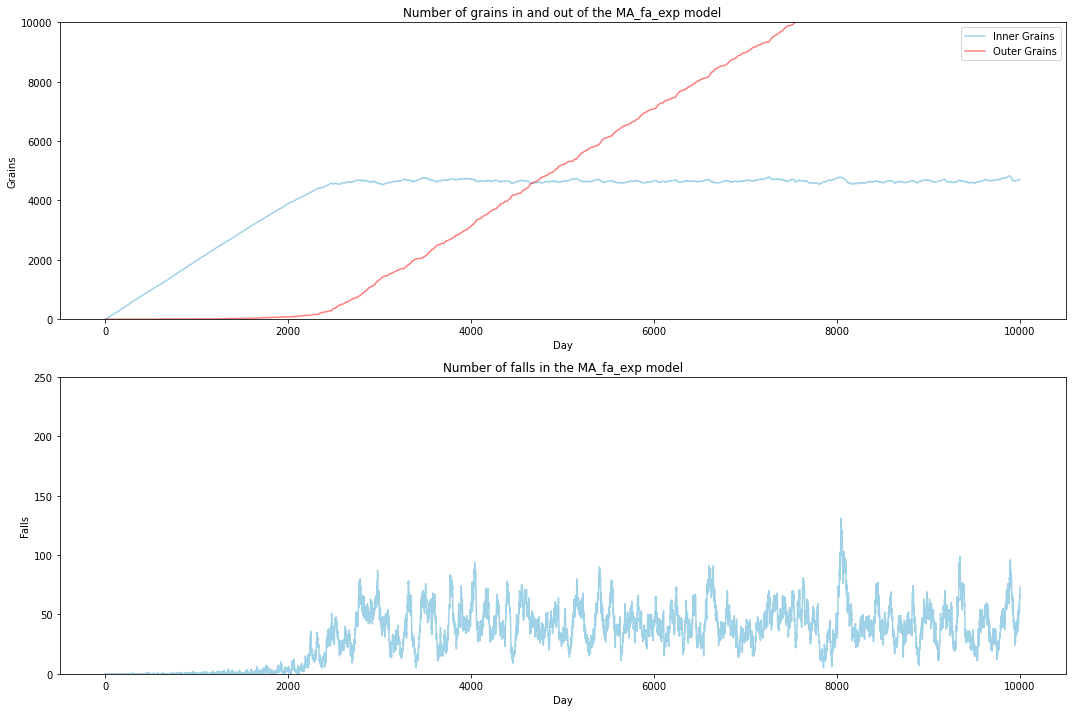

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains_exp, facilitated = True, expon = True)

100%|██████████| 10000/10000 [00:53<00:00, 186.05it/s]


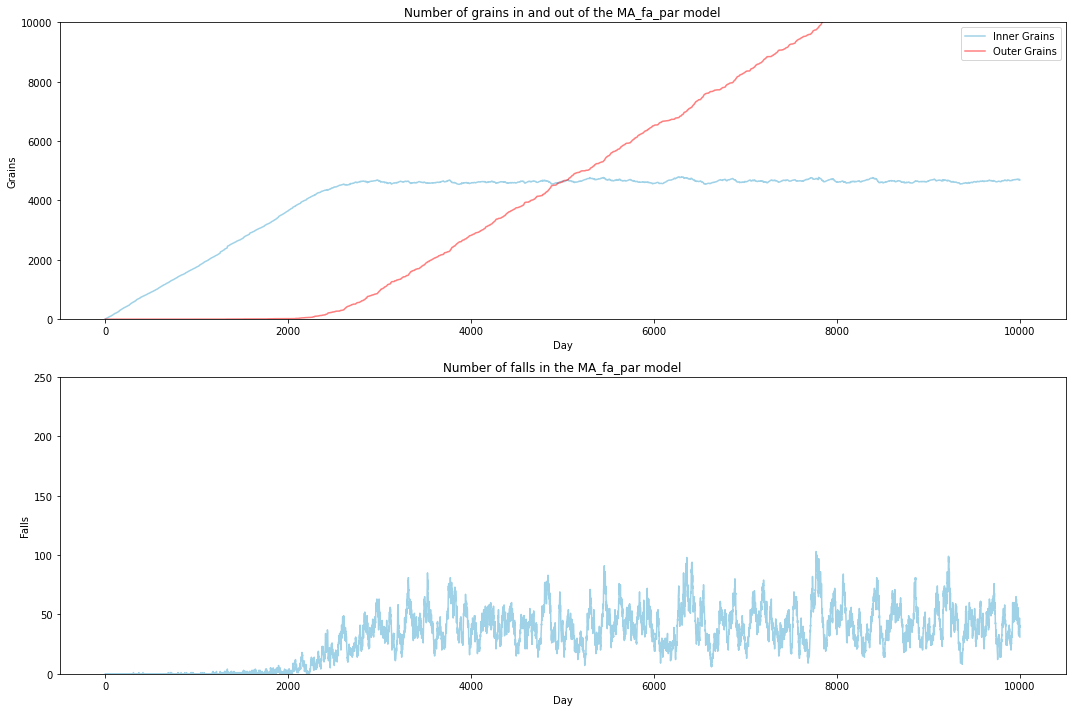

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains_par, facilitated = True, par = True)

### Feder

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:49<00:00, 203.23it/s]


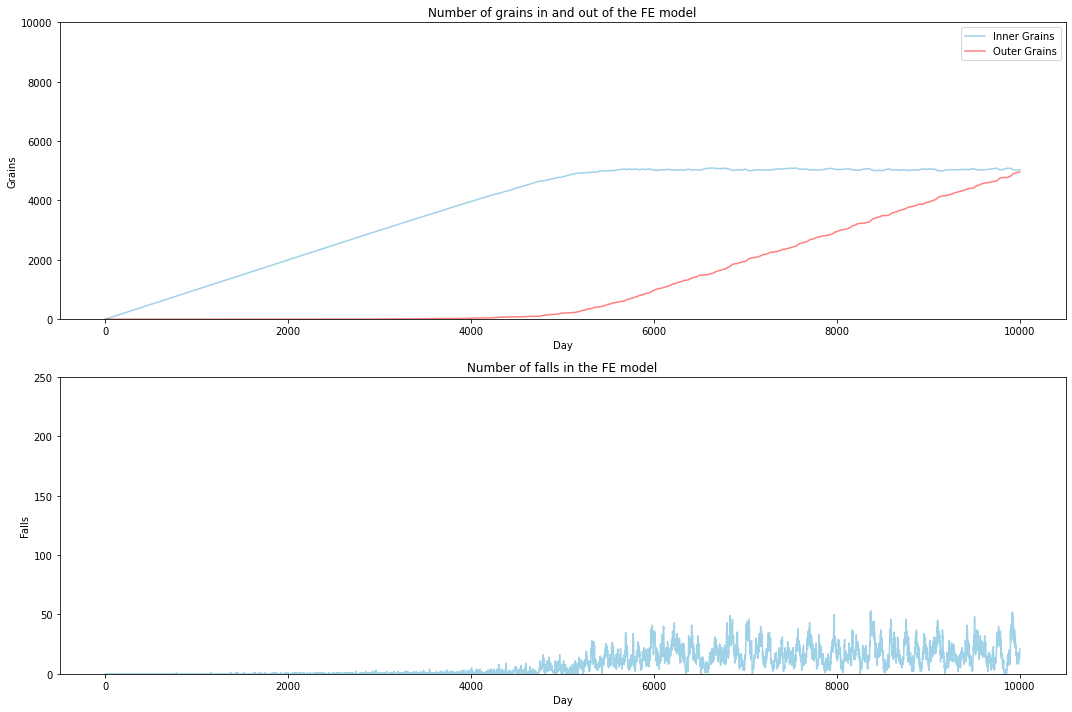

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:03<00:00, 158.24it/s]


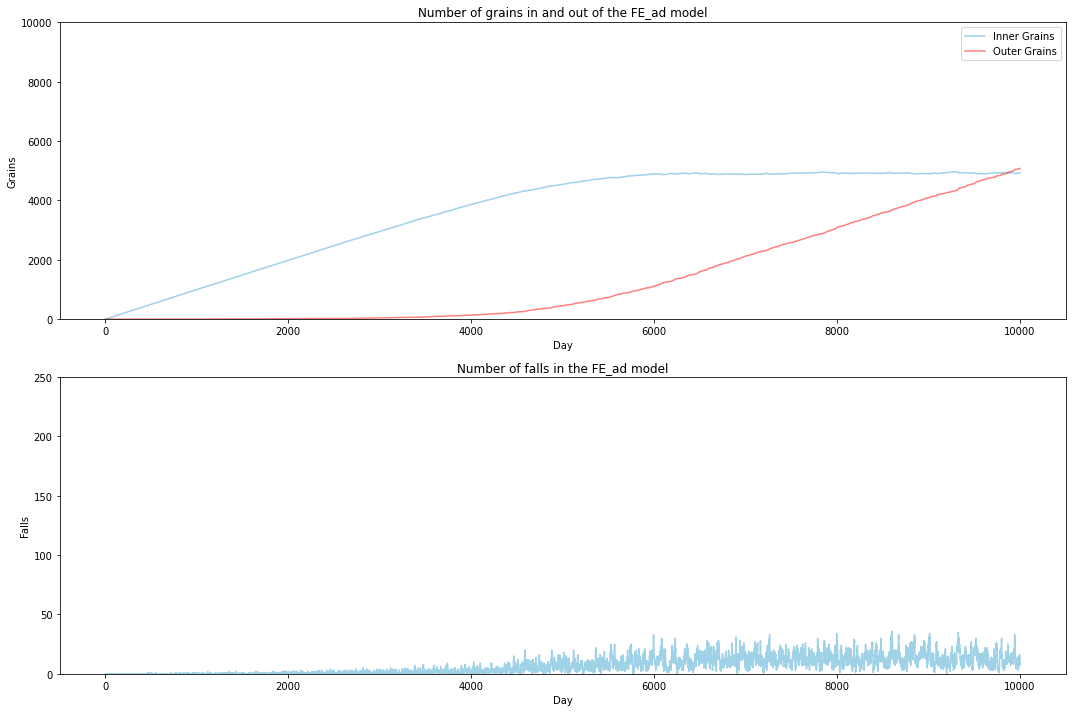

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:54<00:00, 183.63it/s]


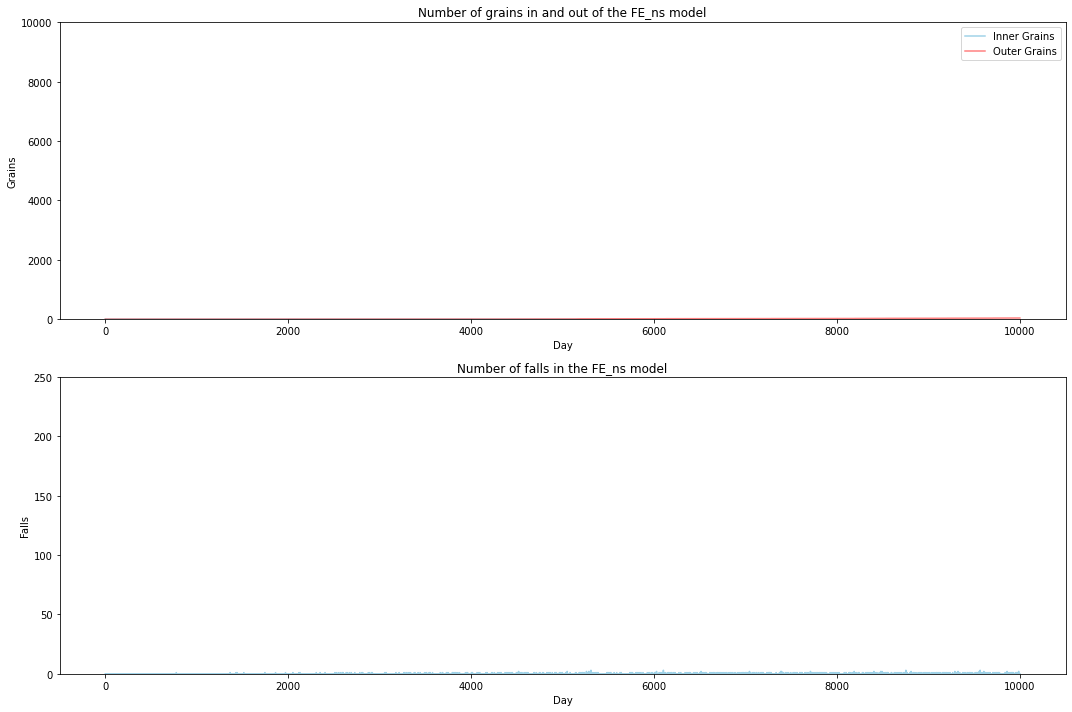

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:47<00:00, 211.18it/s]


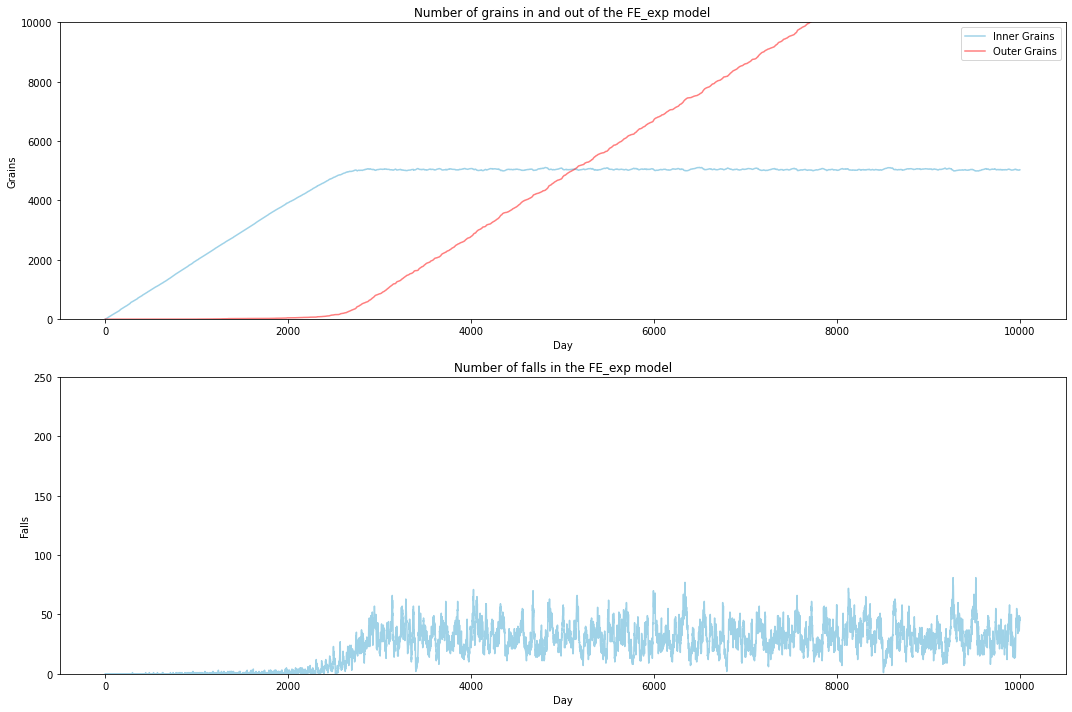

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains_exp, expon = True)

100%|██████████| 10000/10000 [00:47<00:00, 211.02it/s]


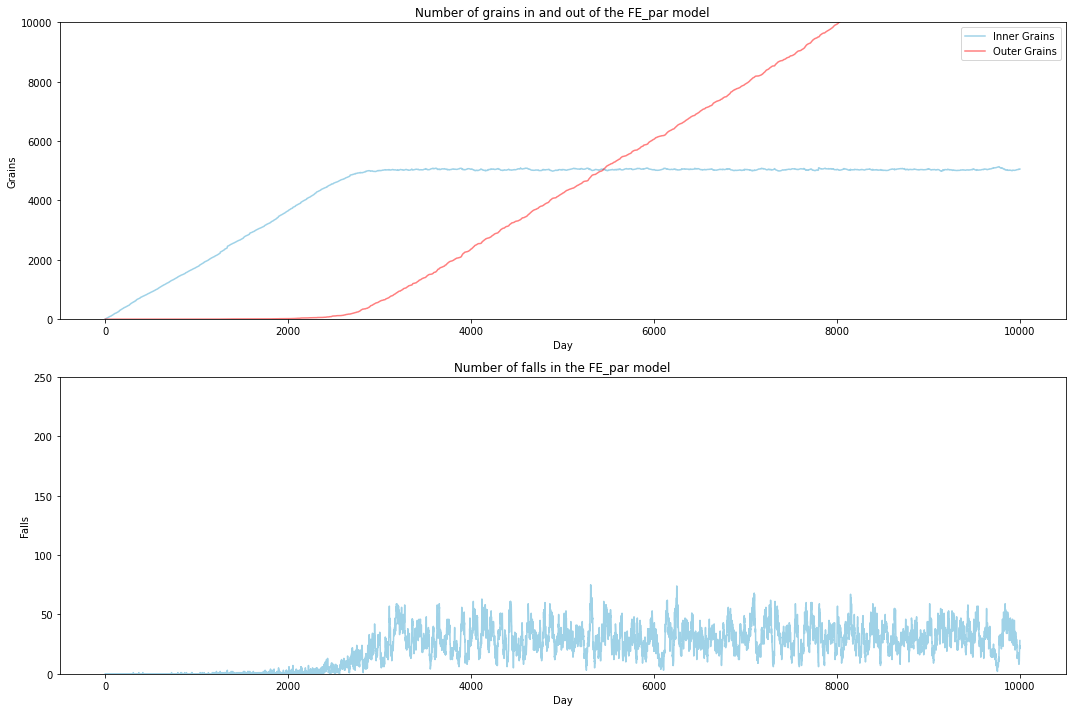

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains_par, par = True)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:49<00:00, 203.21it/s]


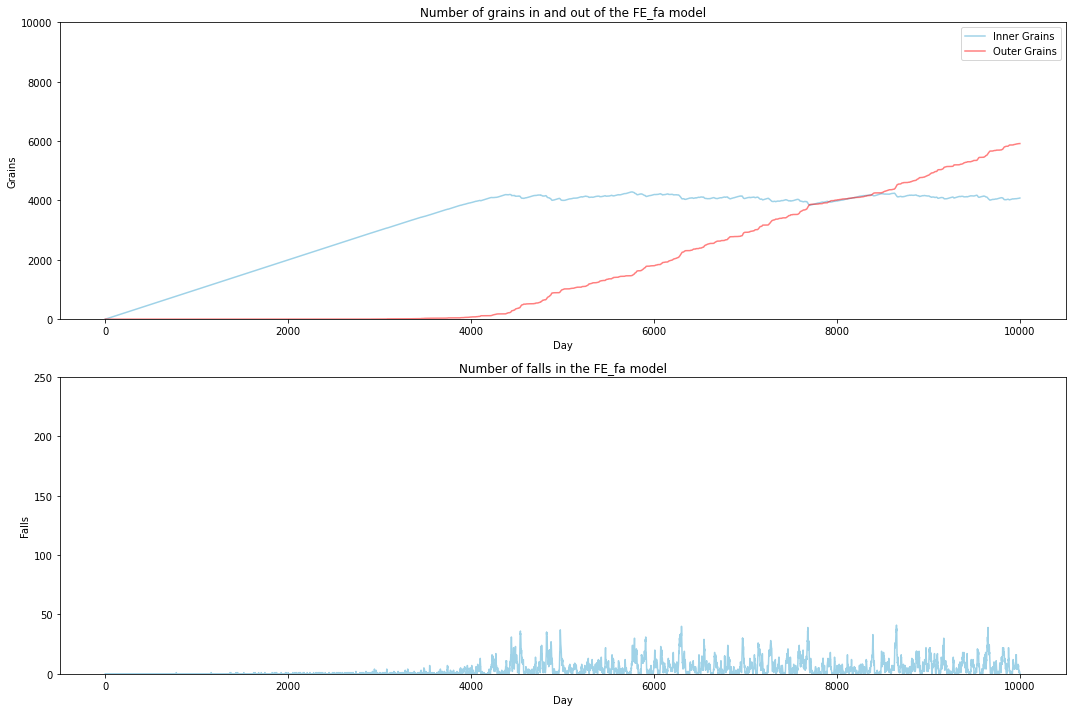

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:04<00:00, 154.70it/s]


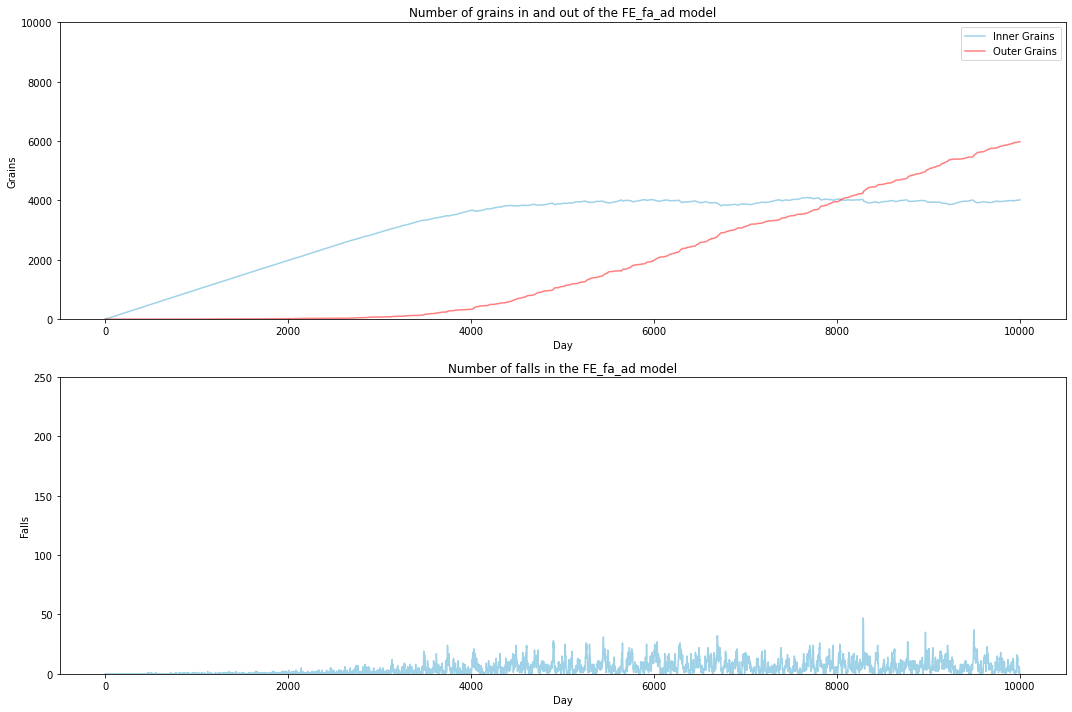

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:57<00:00, 172.98it/s]


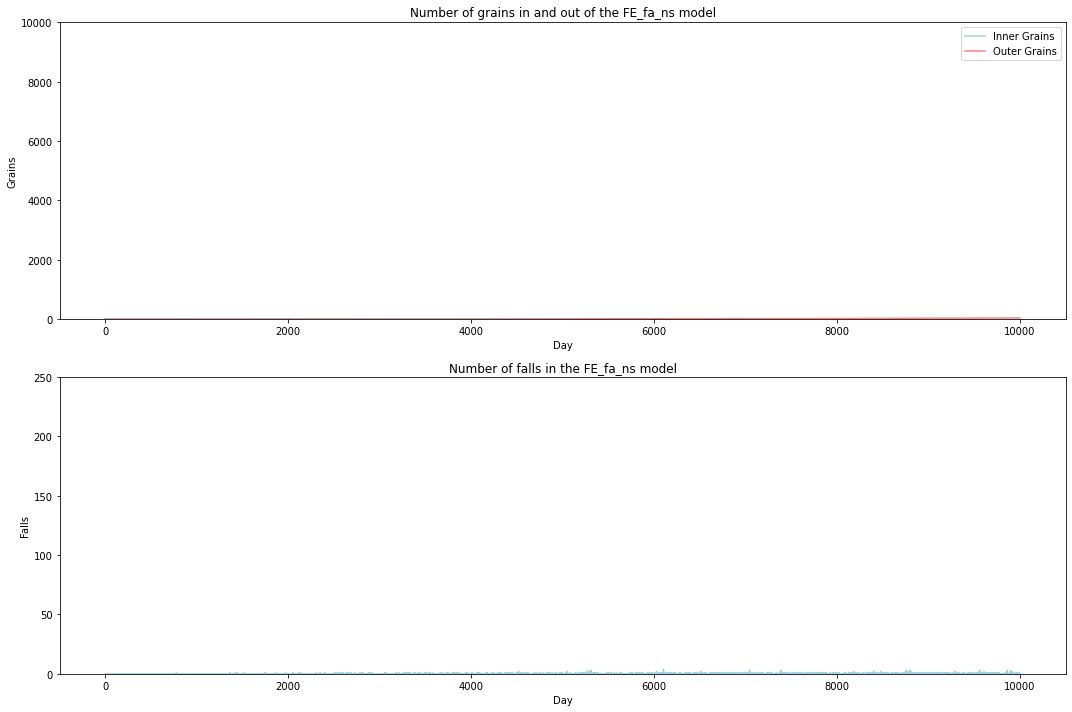

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:56<00:00, 176.71it/s]


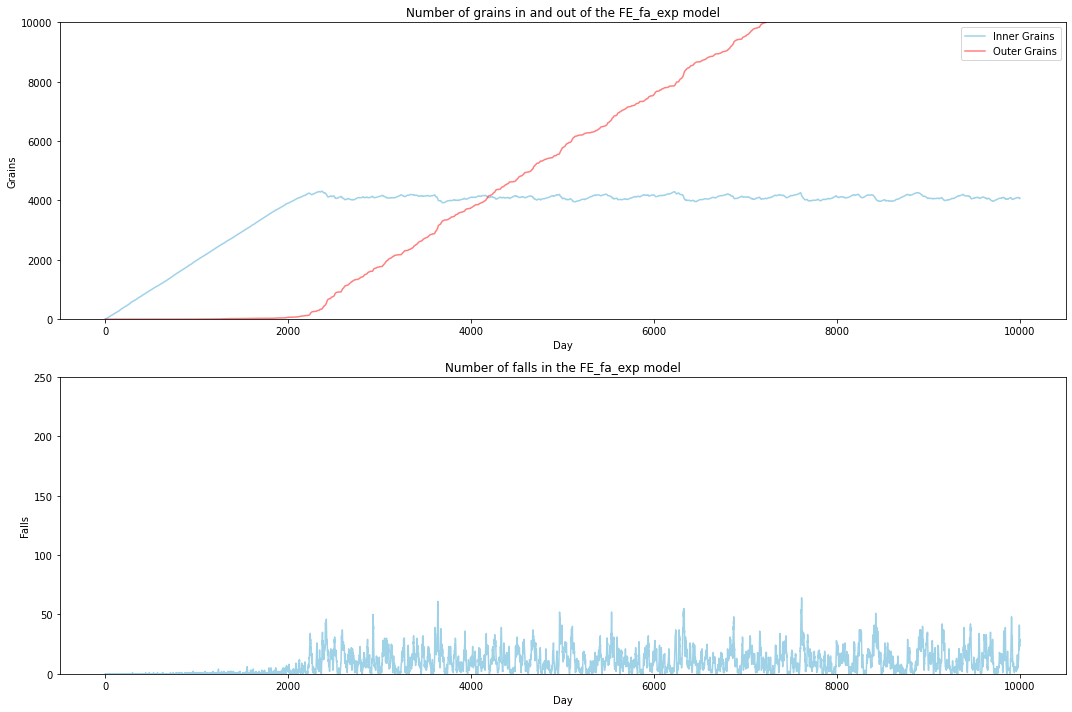

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains_exp, facilitated = True, expon = True)

100%|██████████| 10000/10000 [00:51<00:00, 192.61it/s]


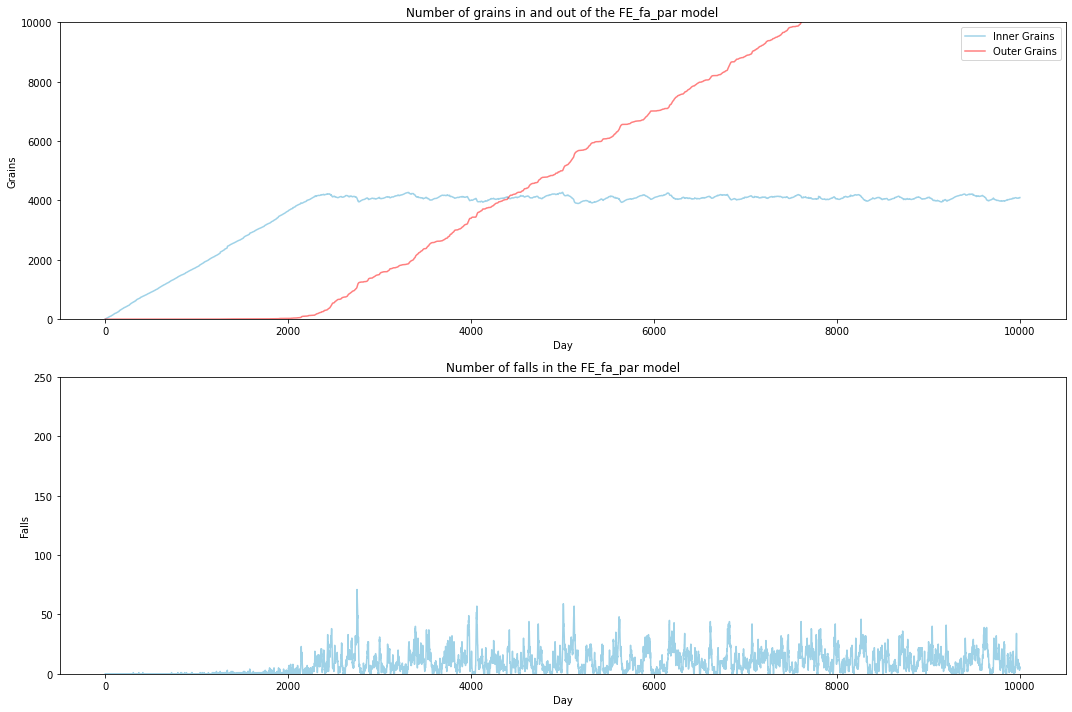

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains_par, facilitated = True, par = True)

### Stochastic Feder

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:46<00:00, 213.40it/s]


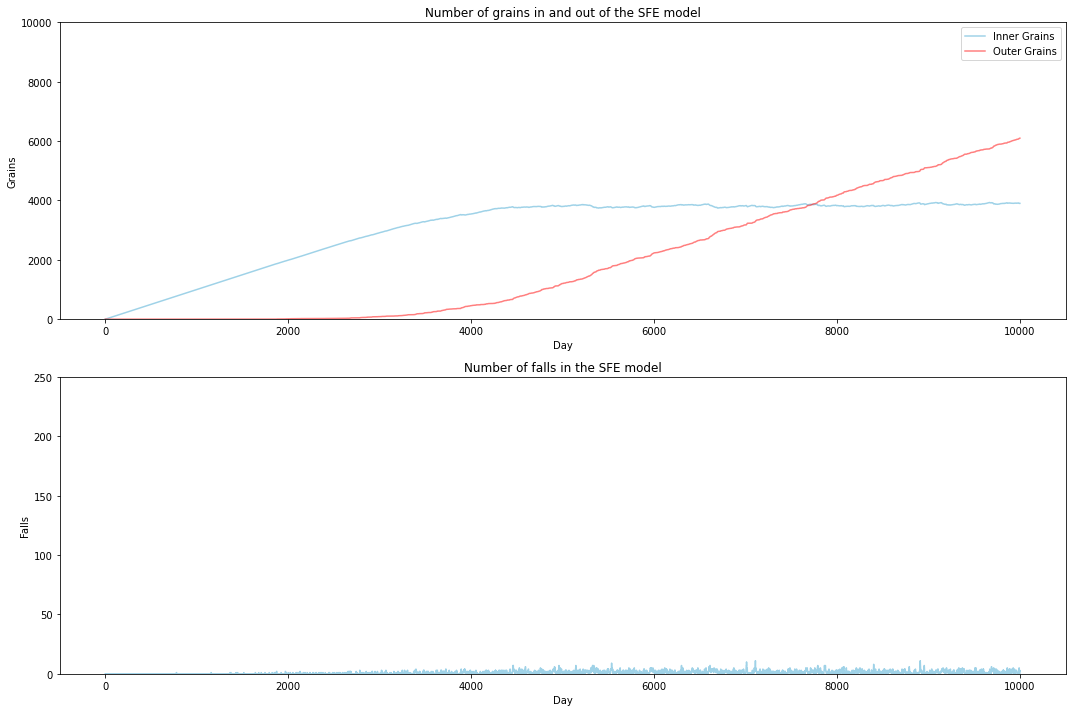

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:02<00:00, 161.29it/s]


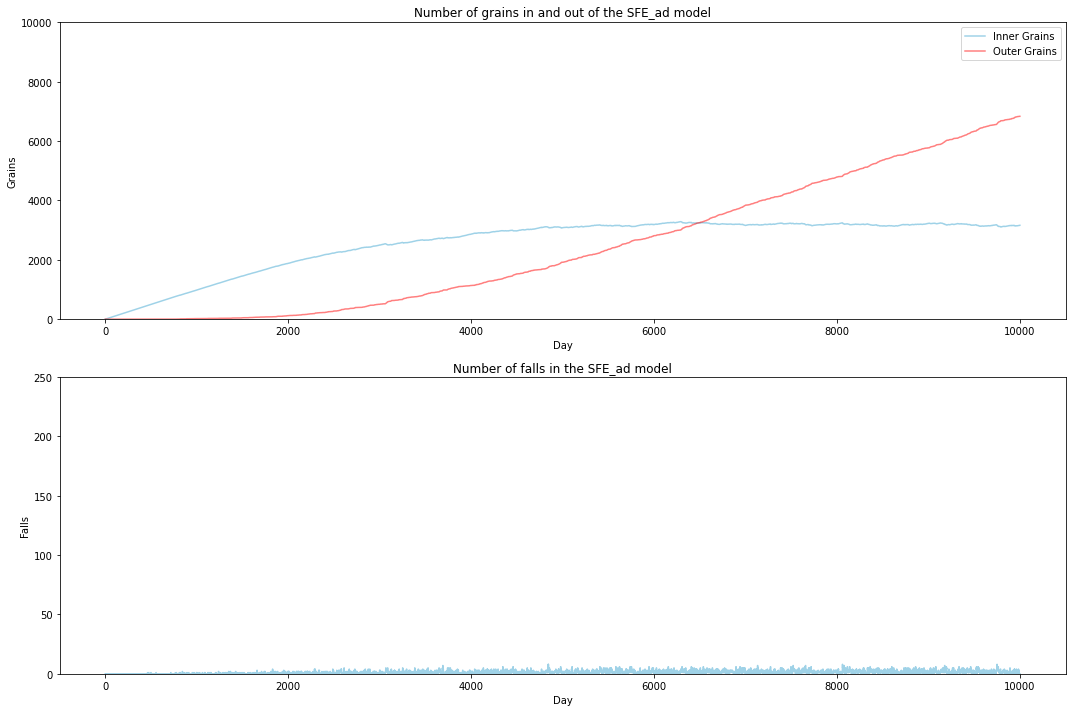

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [00:55<00:00, 179.50it/s]


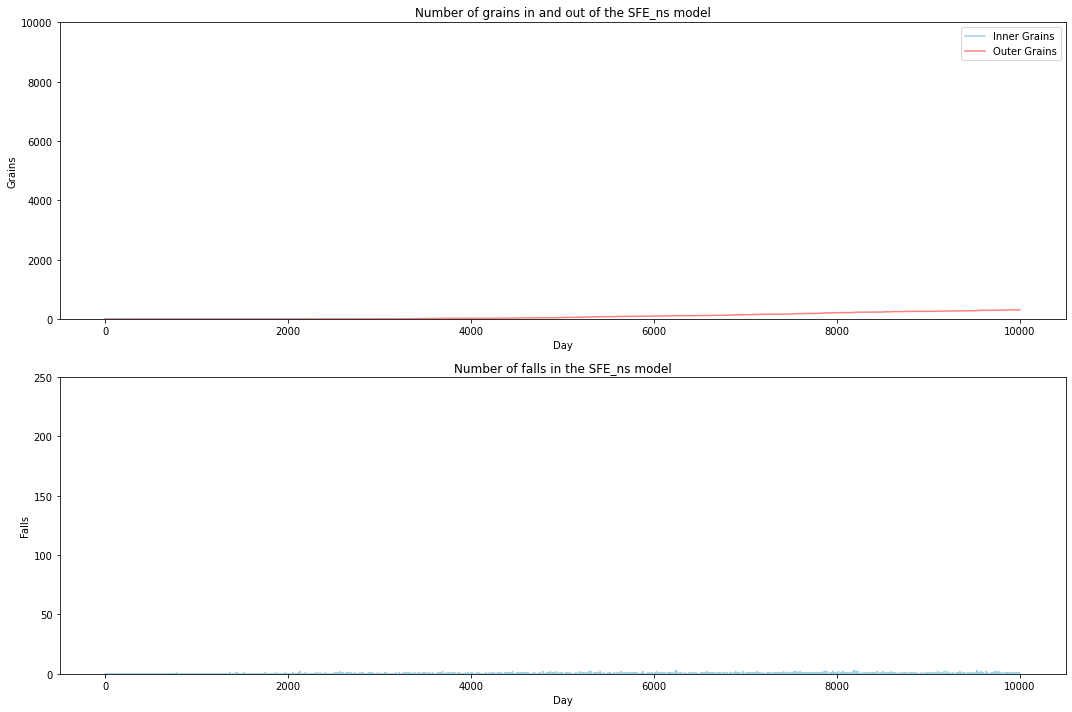

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:51<00:00, 193.34it/s]


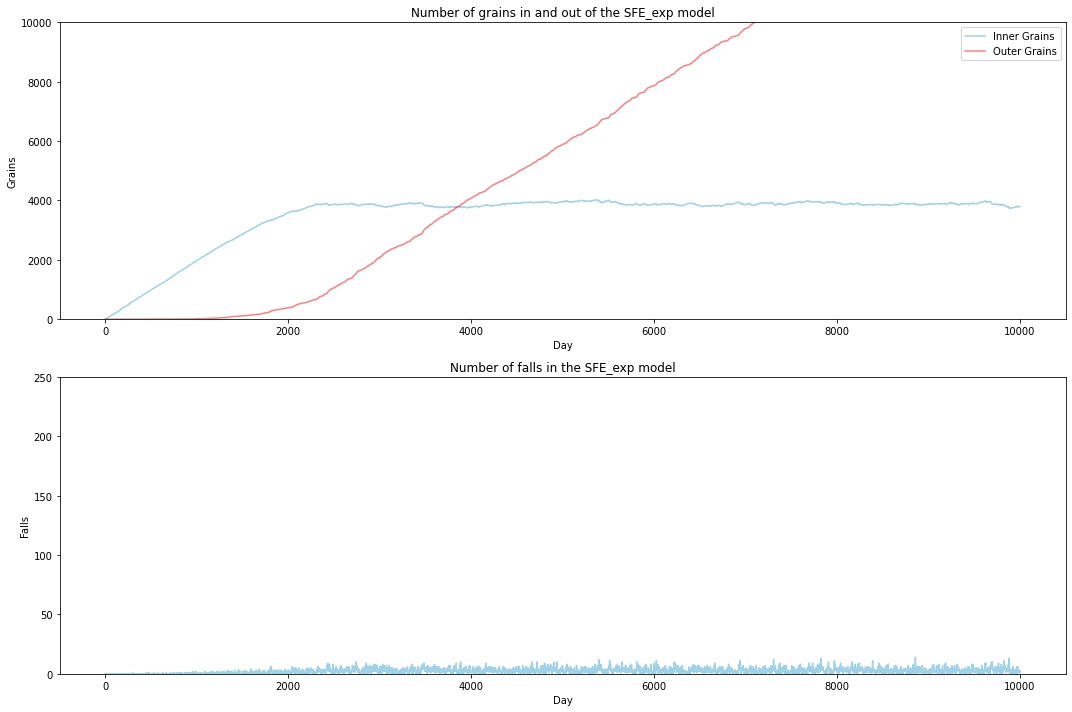

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains_exp, expon = True)

100%|██████████| 10000/10000 [00:46<00:00, 213.34it/s]


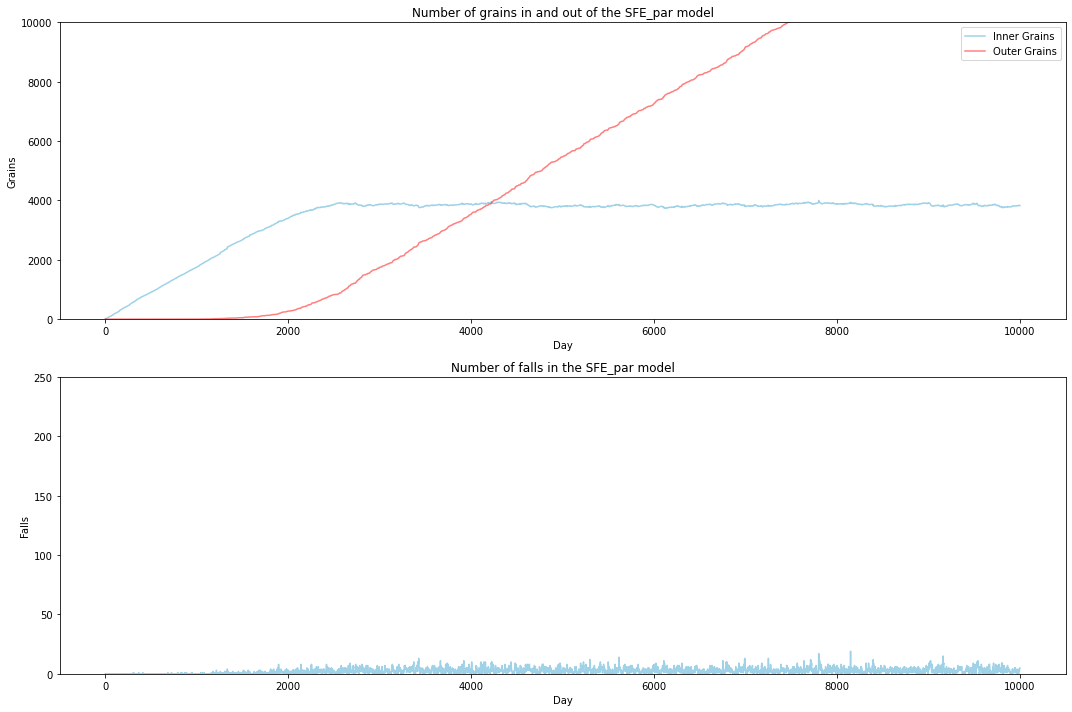

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains_par, par = True)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:49<00:00, 203.21it/s]


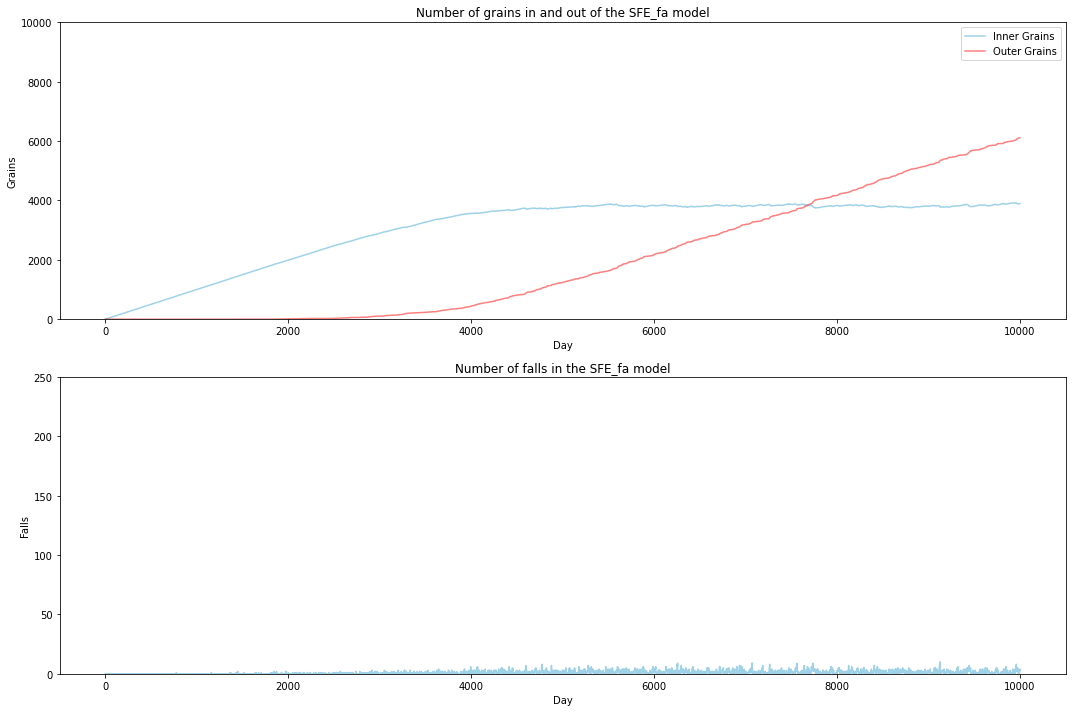

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [01:04<00:00, 155.52it/s]


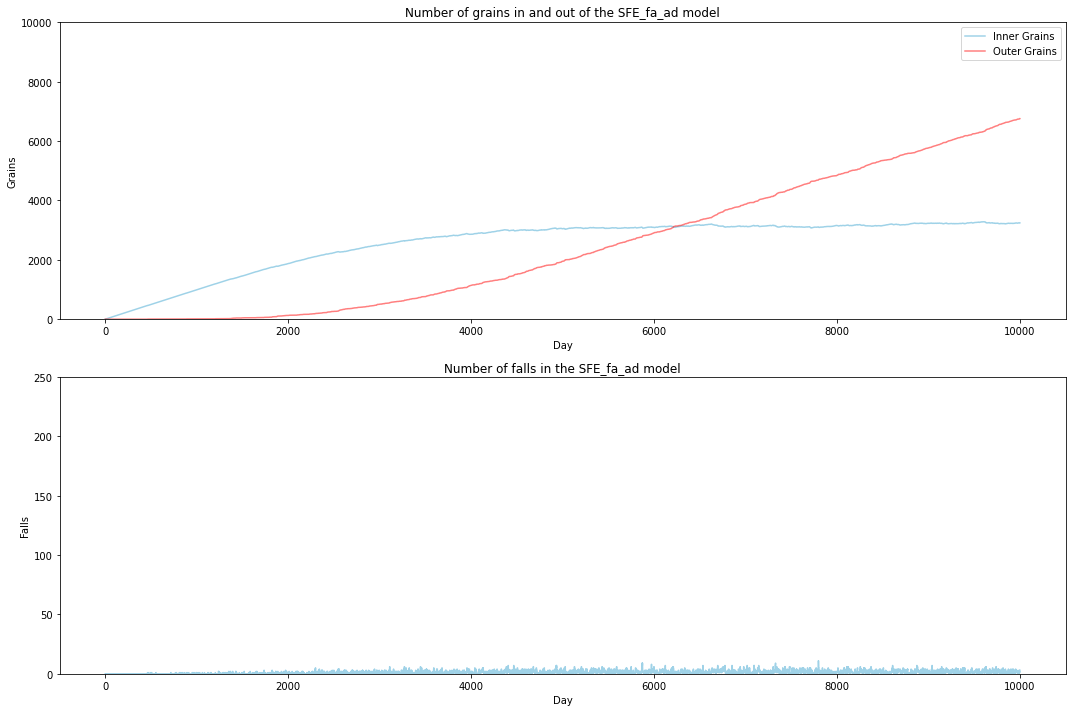

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 10000/10000 [01:00<00:00, 166.00it/s]


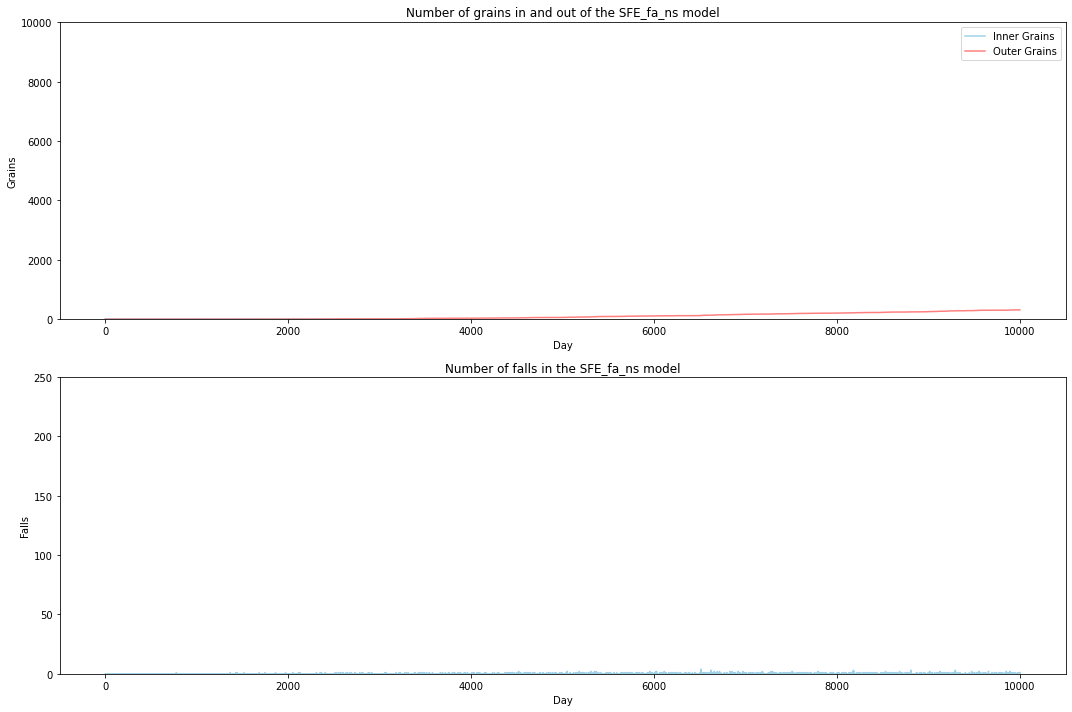

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

##### Additional Pumping

100%|██████████| 10000/10000 [00:51<00:00, 194.45it/s]


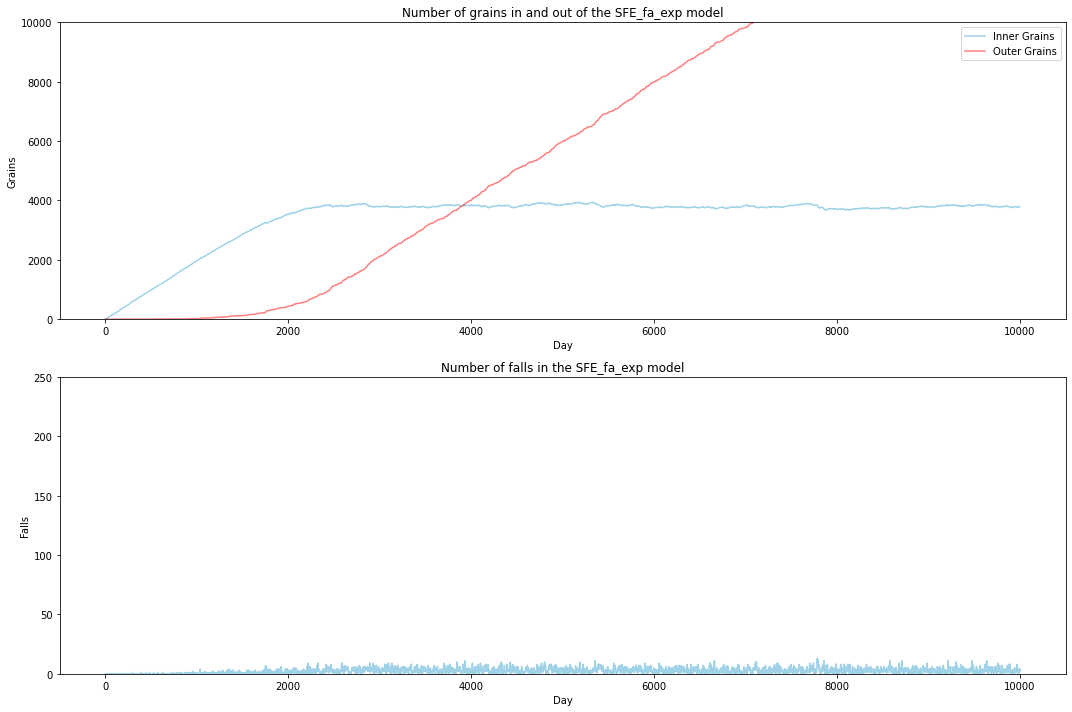

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains_exp, facilitated = True, expon = True)

100%|██████████| 10000/10000 [00:51<00:00, 195.92it/s]


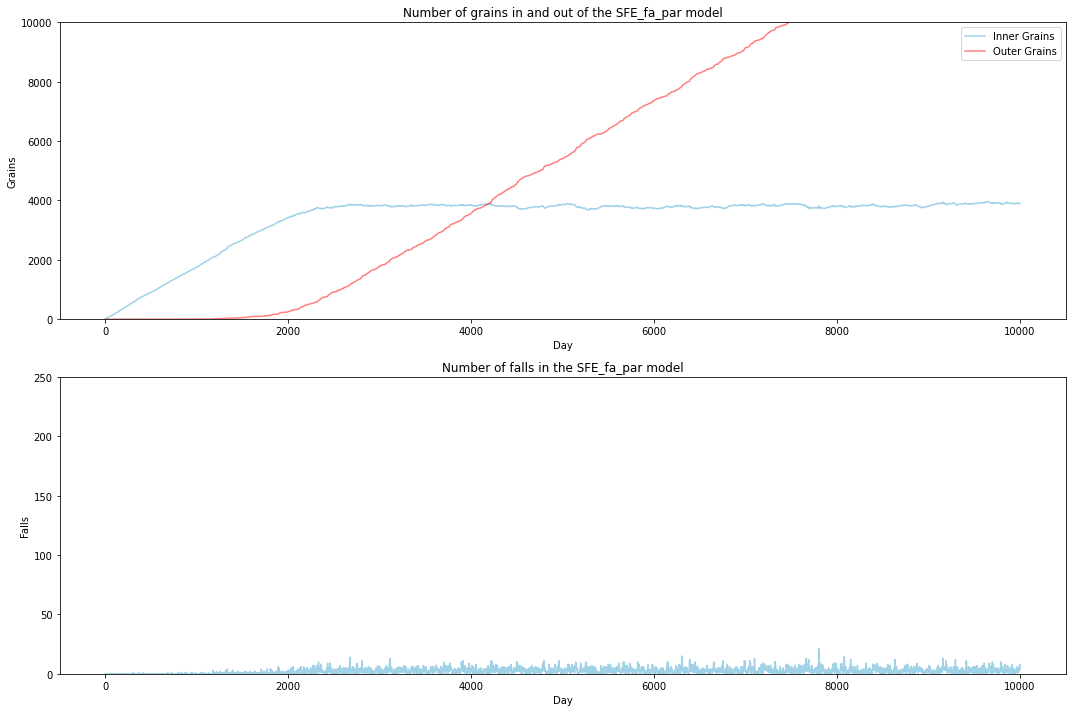

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains_par, facilitated = True, par = True)